In [1]:
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
import pprint
import astropy
from astropy.io import fits
from pathlib import Path
from matplotlib import pyplot as plt
try:
    from tqdm import tqdm
except ModuleNotFoundError:
    tqdm = lambda x: x

In [2]:
!ls /data/TRECS_Outputs

230511	230618


In [3]:
wrapped_file = Path('/data/TRECS_Outputs/230618/catalogue_continuum_wrapped.fits')
wrapped_file.resolve()

PosixPath('/data/TRECS_Outputs/230618/catalogue_continuum_wrapped.fits')

In [4]:
print(f"{wrapped_file.stat().st_size / (1 << 30)} GB")

3.5270968079566956 GB


In [5]:
fits.info(wrapped_file)

Filename: /data/TRECS_Outputs/230618/catalogue_continuum_wrapped.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Catalogue     1 BinTableHDU    186   15521190R x 59C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [6]:
hdu = fits.open(wrapped_file)
hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7efdb9833f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efdb9848890>]

In [7]:
for h in hdu:
    pprint.pprint(h.header)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  244 / width of table in bytes                        
NAXIS2  =             15521190 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                   

In [8]:
catalog = hdu[1].data
print(f"Number of point sources: {len(catalog):,}")

Number of point sources: 15,521,190


## 2D histogram of point source number distribution

In [9]:
cx, cy = catalog['x_coord'], catalog['y_coord']  # in (deg, deg)
i150 = catalog['I150']  # in mJy
a, b = catalog['bmaj'], catalog['bmin']  # in (arcsec, arcsec)
cx, cy

(array([ 0.2618904, -1.151001 ,  1.009634 , ...,  3.9909477, -0.5935478,
        -2.4751148], dtype='>f4'),
 array([ 1.6073284 , -0.85066414,  0.9500332 , ...,  3.8593884 ,
         0.2642746 ,  0.747633  ], dtype='>f4'))

In [10]:
print(cx.min(), cx.max())
print(cy.min(), cy.max())
print("FOV should be 8x8")
assert np.isclose((abs(cx.max()) + abs(cx.min())), 8, rtol=1e-6)
assert np.isclose((abs(cy.max()) + abs(cy.min())), 8, rtol=1e-6)

-4.0 3.999998


-4.0 3.999998
FOV should be 8x8


In [11]:
# 'redshift', 'size'[arcsec], 'inclination'[deg] 'axis ratio', 'PA'[deg]
z, s, incl, q, pa = catalog['redshift'], catalog['size'], catalog['inclination'], catalog['axis ratio'], catalog['PA']
z.min(), z.max()

(1.2130737e-05, 8.099887)

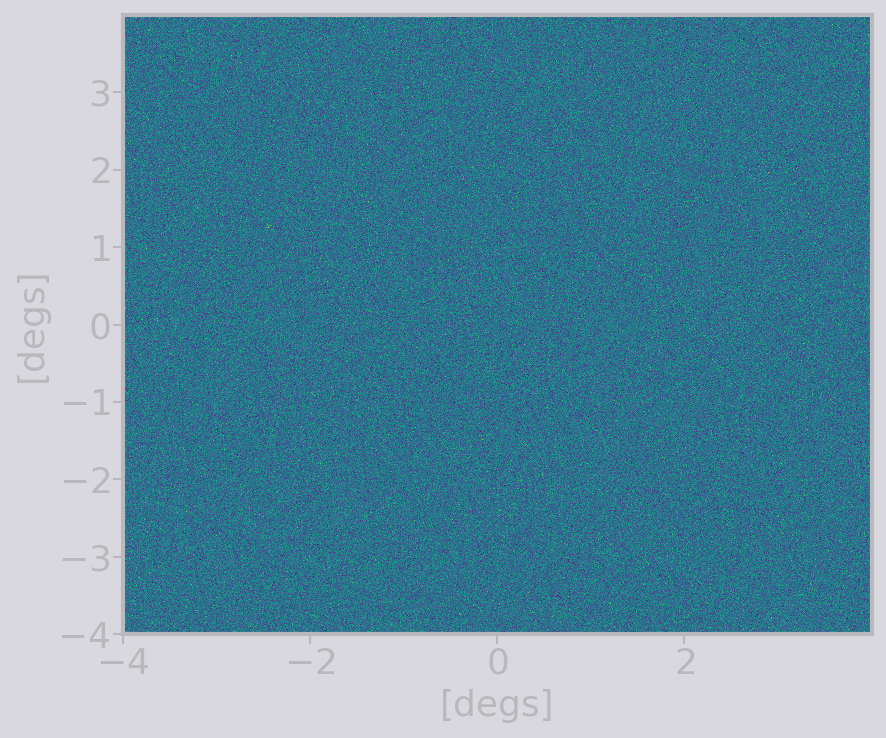

In [12]:
# %%script false --no-raise-error
plt.figure(dpi=150)
# FOV is 8x8 deg: 800x800 bins -> 0.01 deg per bin
nbis = (800, 800)
plt.hist2d(cx, cy, bins=(800, 800))
plt.xlabel('[degs]')
plt.ylabel('[degs]')
plt.show()

## Plotting the total intensity flux densities

In [13]:
frequency_file = list(Path('..').rglob("frequency_list.dat"))[0]
frequency_file.resolve()

PosixPath('/home/phdenzel/TRECS/examples/frequency_list.dat')

In [14]:
frequencies = np.loadtxt(frequency_file)
frequencies

array([  150.,   325.,   408.,   610.,  1400.,  2100.,  3000.,  4800.,
        5500.,  9000., 15000., 18000., 20000.])

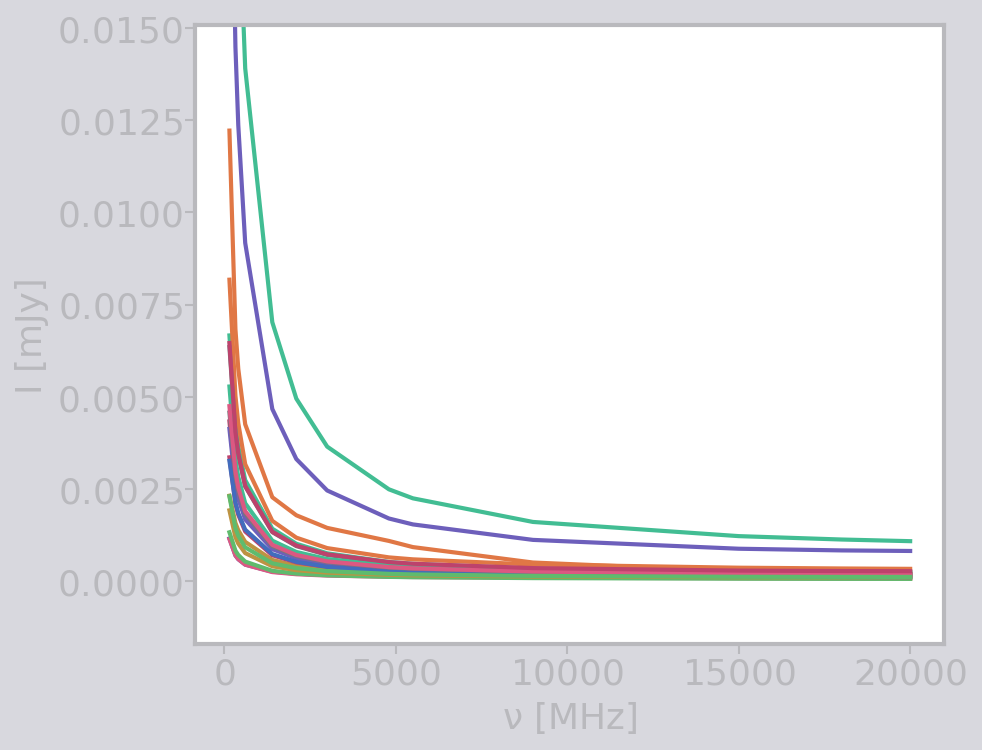

In [15]:
# %%script false --no-raise-error
plt.figure(dpi=150)
random_idcs = np.random.choice(len(catalog), 20)
i150s = [f[3] for f in catalog[random_idcs]]
for i in random_idcs:
    plt.plot(frequencies, catalog[i][3:16])
plt.ylim(top=np.mean(i150s)+np.std(i150s))
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('I [mJy]')
plt.show()

## Plotting the polarized flux densities

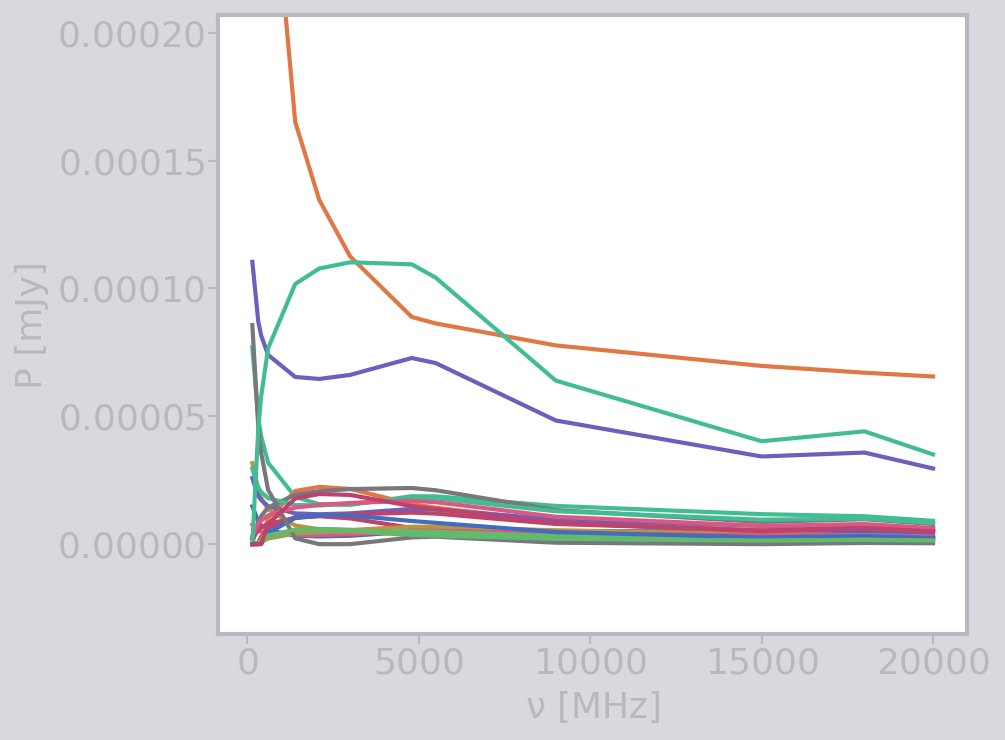

In [16]:
# %%script false --no-raise-error
plt.figure(dpi=150)
p150s = [f[16] for f in catalog[random_idcs]]
for i in random_idcs:
    plt.plot(frequencies, catalog[i][16:29])
plt.ylim(top=np.mean(p150s)+np.std(p150s))
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('P [mJy]')
plt.show() 

## Gridding the TRECS sources

In [17]:
ptsrcs = np.stack((cx, cy, np.abs(a)/3600, np.abs(b)/3600, i150)).T
ptsrcs.shape[0]

15521190

In [18]:
def gaussian_kernel(sigma, k=8, pixel_sampling=1, normalize=True):
    """
    Generate a (uniform) Gaussian kernel with a given standard deviation
    and pixel sampling.

    Note:
        Normalization corresponds analytically to

        kernel *= 1 / (2*np.pi*sigma**2)

        However, when sigma ~ k the kernel is far from Gaussian and
        the error of normalization too high.

    Args:
        sigma (float): standard deviation of the Gaussian in physical units, e.g. arcsec
        k (int, float): kernel size in pixels, i.e. square length of the kernel
        pixel_sampling (float): physical units per pixel, e.g. arcsec/px

    Returns:
        kernel (np.ndarray):
            in units per squared physical units (if normalized), e.g. arcsec^(-2)
    """
    k_range = np.arange(-k//2, k//2+1) * pixel_sampling
    xx, yy = np.meshgrid(k_range, k_range)
    kernel = np.exp(-0.5*(xx**2 + yy**2) / sigma**2)
    if normalize:
        # kernel = kernel / (2*np.pi*sigma**2)
        kernel = kernel / (pixel_sampling**2 * kernel.sum())
    return kernel

In [19]:
def grid_sources(pts, fov, fwhm=2, pixel_sampling=1, f_kernel=4, batch_size=0):
    """
    Args:
        pts (np.ndarray): point-source data stacked as (x, y, maj_axis, min_axis, flux).T
            in units of [deg] and the integrated flux in units of [mJy]
        fov (float): field of view in [deg]
        fwhm (float): FWHM of the Gaussian kernel in arcsec
        f_kernel (int): kernel factor as extent multiplier
        pixel_sampling (float): physical units per pixel, e.g. arcsec/px
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # in arcsec
    fwhm_px = int(fwhm / pixel_sampling)         # in pixels
    k = int(f_kernel * fwhm_px)                  # kernel size in pixels
    grid_size = int(3600*fov/pixel_sampling)
    
    kernel = gaussian_kernel(sigma, k=k, pixel_sampling=pixel_sampling, normalize=True)
    # add some margins to the grid for convolution
    grid = np.zeros((grid_size + k, grid_size + k))

    # precompute the coordinates in pixel units
    pts[:, 0] = np.int_(grid.shape[0]//2 + 3600*pts[:, 0]/pixel_sampling) - k//2
    pts[:, 1] = np.int_(grid.shape[1]//2 + 3600*pts[:, 1]/pixel_sampling) - k//2

    # convolve each source's kernel with the grid
    for src in tqdm(pts):
        mu_x, mu_y, _, _, amplitude = src
        src_kernel = kernel * amplitude
        # print(mu_x, mu_y, amplitude)
        src_grid = src_kernel
        u, d, l, r = int(mu_y), int(mu_y+k)+1, int(mu_x), int(mu_x+k)+1
        # src_grid = convolve(grid[u:d, l:r], src_kernel, mode='constant')
        # src_grid = fftconvolve(grid[u:d, l:r], src_kernel, mode='same')
        grid[u:d, l:r] += src_grid
    return grid

### Sanity checks, testing

In [20]:
# define the kernel and grid parameters
fov = 8.0             # field of view in deg 
pixel_sampling = 5.0  # arcsec per pixel
fwhm = 10.0           # FWHM of the Gaussian kernel in arcsec
f_kernel = 8          # adjust the factor based on your needs
                      # larger kernels sample Gaussians more precisely,
                      # but are computationally more expensive

sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # in arcsec
fwhm_pixels = int(fwhm / pixel_sampling)     # in pixels
sigma_pixels = sigma / pixel_sampling        # in pixels
kernel_size = int(f_kernel * fwhm_pixels)    # in pixels
# add some margins to the grid for convolution
grid_size = int(3600*fov/pixel_sampling) + kernel_size

f"{fov=} {pixel_sampling=} {fwhm=} {f_kernel=}  {sigma=:.4f} {fwhm_pixels=} {sigma_pixels=} {kernel_size=} {grid_size=}"

'fov=8.0 pixel_sampling=5.0 fwhm=10.0 f_kernel=8  sigma=4.2466 fwhm_pixels=2 sigma_pixels=0.8493218002880191 kernel_size=16 grid_size=5776'

In [21]:
gk1 = gaussian_kernel(sigma, k=kernel_size, pixel_sampling=pixel_sampling, normalize=True)
gk2 = gaussian_kernel(sigma, k=kernel_size, pixel_sampling=pixel_sampling, normalize=False)
print(gk1.sum()*5**2)

1.0


In [22]:
test_amp = 1e6
test_pts = np.array([[0, 0, 0.005, 0.005, test_amp]])
test_grid = grid_sources(test_pts, fov=1, fwhm=10, pixel_sampling=5)
test_grid.sum()*pixel_sampling**2, test_grid.max()*pixel_sampling**2

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00, 13189.64it/s]

(1000000.0000000002, 220635.0345638155)

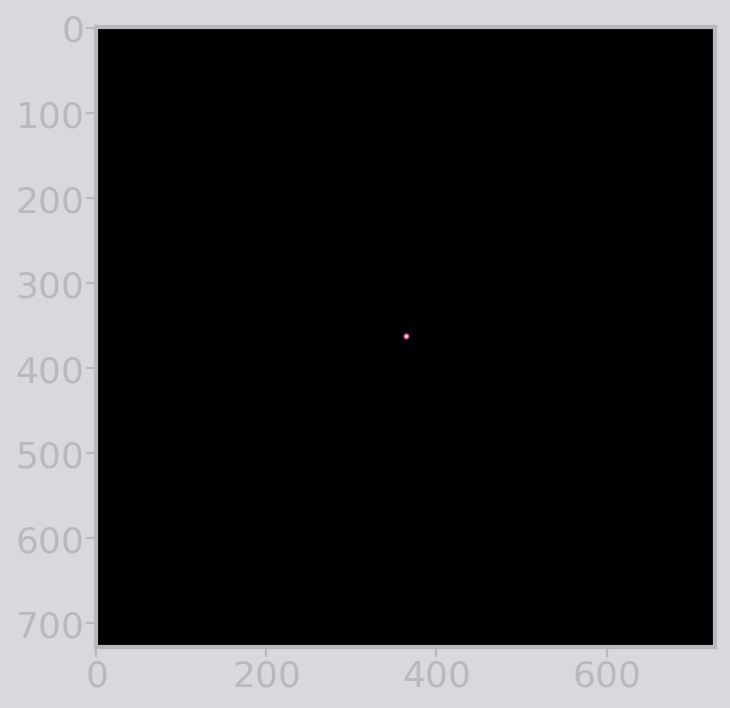

In [23]:
# %%script false --no-raise-error
plt.figure(dpi=150)
plt.imshow(np.log(1+test_grid*pixel_sampling**2), cmap='magma')
plt.show()

In [24]:
int_flux_per_pixel = np.sum(test_grid)
int_flux = int_flux_per_pixel * pixel_sampling**2
assert np.isclose(int_flux, test_amp, rtol=1e-3)
f"Integrated flux: {int_flux} is close to 1e6"

'Integrated flux: 1000000.0000000002 is close to 1e6'

### Gridding the catalog

In [25]:
cat_grid = grid_sources(ptsrcs, fov=fov, fwhm=fwhm, pixel_sampling=pixel_sampling,
                        f_kernel=f_kernel)

  0% 0/15521190 [00:00<?, ?it/s]

  0% 3238/15521190 [00:00<07:59, 32375.79it/s]

  0% 9909/15521190 [00:00<04:55, 52567.42it/s]

  0% 20176/15521190 [00:00<03:25, 75440.48it/s]

  0% 30700/15521190 [00:00<02:57, 87200.29it/s]

  0% 40390/15521190 [00:00<02:50, 90694.97it/s]

  0% 50162/15521190 [00:00<02:46, 93079.58it/s]

  0% 59470/15521190 [00:00<02:48, 91659.41it/s]

  0% 69101/15521190 [00:00<02:45, 93121.34it/s]

  1% 78703/15521190 [00:00<02:44, 94019.83it/s]

  1% 89807/15521190 [00:01<02:35, 99246.25it/s]

  1% 100451/15521190 [00:01<02:32, 101439.17it/s]

  1% 110630/15521190 [00:01<02:31, 101539.34it/s]

  1% 120981/15521190 [00:01<02:30, 102132.14it/s]

  1% 132223/15521190 [00:01<02:26, 105234.29it/s]

  1% 142980/15521190 [00:01<02:25, 105934.86it/s]

  1% 153575/15521190 [00:01<02:27, 104296.62it/s]

  1% 164932/15521190 [00:01<02:23, 107050.73it/s]

  1% 176355/15521190 [00:01<02:20, 109188.45it/s]

  1% 187281/15521190 [00:01<02:24, 106206.03it/s]

  1% 198365/15521190 [00:02<02:22, 107562.55it/s]

  1% 209361/15521190 [00:02<02:21, 108263.08it/s]

  1% 220202/15521190 [00:02<02:24, 106018.68it/s]

  1% 230886/15521190 [00:02<02:23, 106257.58it/s]

  2% 241525/15521190 [00:02<02:30, 101551.49it/s]

  2% 252377/15521190 [00:02<02:27, 103550.35it/s]

  2% 262775/15521190 [00:02<02:28, 102781.99it/s]

  2% 273400/15521190 [00:02<02:26, 103792.64it/s]

  2% 284911/15521190 [00:02<02:22, 107119.00it/s]

  2% 296264/15521190 [00:02<02:19, 109015.11it/s]

  2% 307184/15521190 [00:03<02:20, 108235.33it/s]

  2% 318241/15521190 [00:03<02:19, 108924.37it/s]

  2% 329285/15521190 [00:03<02:18, 109374.22it/s]

  2% 340231/15521190 [00:03<02:22, 106822.28it/s]

  2% 351493/15521190 [00:03<02:19, 108524.00it/s]

  2% 362362/15521190 [00:03<02:25, 104273.73it/s]

  2% 372832/15521190 [00:03<02:33, 98842.07it/s] 

  2% 383066/15521190 [00:03<02:31, 99821.63it/s]

  3% 393107/15521190 [00:03<02:32, 99207.70it/s]

  3% 403258/15521190 [00:03<02:31, 99870.00it/s]

  3% 414521/15521190 [00:04<02:25, 103592.00it/s]

  3% 425480/15521190 [00:04<02:23, 105351.85it/s]

  3% 436041/15521190 [00:04<02:30, 99976.81it/s] 

  3% 447264/15521190 [00:04<02:25, 103482.84it/s]

  3% 458478/15521190 [00:04<02:22, 105993.76it/s]

  3% 469132/15521190 [00:04<02:26, 102840.60it/s]

  3% 480241/15521190 [00:04<02:22, 105219.88it/s]

  3% 491295/15521190 [00:04<02:20, 106770.70it/s]

  3% 502454/15521190 [00:04<02:18, 108187.13it/s]

  3% 513592/15521190 [00:05<02:17, 109129.92it/s]

  3% 524725/15521190 [00:05<02:16, 109779.61it/s]

  3% 535719/15521190 [00:05<02:24, 103485.93it/s]

  4% 546151/15521190 [00:05<02:24, 103638.37it/s]

  4% 557094/15521190 [00:05<02:22, 105315.78it/s]

  4% 567673/15521190 [00:05<02:26, 101850.46it/s]

  4% 578027/15521190 [00:05<02:26, 102332.31it/s]

  4% 588299/15521190 [00:05<02:32, 98093.83it/s] 

  4% 599349/15521190 [00:05<02:26, 101628.07it/s]

  4% 609569/15521190 [00:05<02:28, 100608.17it/s]

  4% 620831/15521190 [00:06<02:23, 104089.73it/s]

  4% 632185/15521190 [00:06<02:19, 106854.95it/s]

  4% 642905/15521190 [00:06<02:22, 104651.42it/s]

  4% 654278/15521190 [00:06<02:18, 107299.71it/s]

  4% 665521/15521190 [00:06<02:16, 108807.23it/s]

  4% 676531/15521190 [00:06<02:15, 109187.08it/s]

  4% 687467/15521190 [00:06<02:19, 105995.98it/s]

  5% 698878/15521190 [00:06<02:16, 108361.03it/s]

  5% 710212/15521190 [00:06<02:14, 109822.46it/s]

  5% 721339/15521190 [00:06<02:14, 110249.96it/s]

  5% 732381/15521190 [00:07<02:14, 109660.81it/s]

  5% 743538/15521190 [00:07<02:14, 110226.63it/s]

  5% 754988/15521190 [00:07<02:12, 111496.80it/s]

  5% 766145/15521190 [00:07<02:15, 108526.19it/s]

  5% 777188/15521190 [00:07<02:15, 109082.37it/s]

  5% 788607/15521190 [00:07<02:13, 110588.36it/s]

  5% 799680/15521190 [00:07<02:19, 105202.36it/s]

  5% 810261/15521190 [00:07<02:21, 104089.32it/s]

  5% 821251/15521190 [00:07<02:18, 105763.76it/s]

  5% 832039/15521190 [00:08<02:18, 106378.84it/s]

  5% 843085/15521190 [00:08<02:16, 107576.76it/s]

  6% 854521/15521190 [00:08<02:13, 109582.79it/s]

  6% 865720/15521190 [00:08<02:12, 110296.65it/s]

  6% 877140/15521190 [00:08<02:11, 111458.45it/s]

  6% 888296/15521190 [00:08<02:13, 109787.00it/s]

  6% 899320/15521190 [00:08<02:13, 109919.47it/s]

  6% 910388/15521190 [00:08<02:12, 110143.69it/s]

  6% 921409/15521190 [00:08<02:19, 104574.42it/s]

  6% 931927/15521190 [00:08<02:20, 103739.50it/s]

  6% 942730/15521190 [00:09<02:18, 104978.78it/s]

  6% 953261/15521190 [00:09<02:23, 101832.12it/s]

  6% 964684/15521190 [00:09<02:18, 105404.15it/s]

  6% 976046/15521190 [00:09<02:14, 107797.96it/s]

  6% 987461/15521190 [00:09<02:12, 109662.54it/s]

  6% 998776/15521190 [00:09<02:11, 110690.61it/s]

  7% 1009867/15521190 [00:09<02:14, 107550.66it/s]

  7% 1020655/15521190 [00:09<02:15, 106670.67it/s]

  7% 1032066/15521190 [00:09<02:13, 108842.31it/s]

  7% 1043474/15521190 [00:09<02:11, 110382.32it/s]

  7% 1054712/15521190 [00:10<02:10, 110970.75it/s]

  7% 1066240/15521190 [00:10<02:08, 112249.69it/s]

  7% 1077604/15521190 [00:10<02:08, 112660.43it/s]

  7% 1088993/15521190 [00:10<02:07, 113023.51it/s]

  7% 1100301/15521190 [00:10<02:07, 112799.56it/s]

  7% 1111586/15521190 [00:10<02:07, 112812.82it/s]

  7% 1123082/15521190 [00:10<02:06, 113453.80it/s]

  7% 1134430/15521190 [00:10<02:07, 113254.19it/s]

  7% 1145757/15521190 [00:10<02:10, 110139.48it/s]

  7% 1156987/15521190 [00:10<02:09, 110770.89it/s]

  8% 1168220/15521190 [00:11<02:09, 111230.56it/s]

  8% 1179702/15521190 [00:11<02:07, 112293.15it/s]

  8% 1190941/15521190 [00:11<02:12, 108379.01it/s]

  8% 1202467/15521190 [00:11<02:09, 110378.13it/s]

  8% 1213535/15521190 [00:11<02:09, 110215.71it/s]

  8% 1224577/15521190 [00:11<02:12, 107833.98it/s]

  8% 1235987/15521190 [00:11<02:10, 109661.56it/s]

  8% 1247411/15521190 [00:11<02:08, 111006.42it/s]

  8% 1258529/15521190 [00:11<02:12, 107300.03it/s]

  8% 1269333/15521190 [00:12<02:12, 107513.32it/s]

  8% 1280110/15521190 [00:12<02:13, 106538.19it/s]

  8% 1290938/15521190 [00:12<02:12, 107047.65it/s]

  8% 1302282/15521190 [00:12<02:10, 108932.77it/s]

  8% 1313188/15521190 [00:12<02:10, 108910.39it/s]

  9% 1324505/15521190 [00:12<02:08, 110173.88it/s]

  9% 1335820/15521190 [00:12<02:07, 111057.91it/s]

  9% 1346932/15521190 [00:12<02:12, 106585.85it/s]

  9% 1358257/15521190 [00:12<02:10, 108521.11it/s]

  9% 1369145/15521190 [00:12<02:18, 102311.74it/s]

  9% 1380066/15521190 [00:13<02:15, 104263.03it/s]

  9% 1390687/15521190 [00:13<02:14, 104820.66it/s]

  9% 1401611/15521190 [00:13<02:13, 106106.87it/s]

  9% 1412638/15521190 [00:13<02:11, 107329.58it/s]

  9% 1423403/15521190 [00:13<02:13, 105485.68it/s]

  9% 1433979/15521190 [00:13<02:14, 104900.01it/s]

  9% 1444488/15521190 [00:13<02:16, 103149.68it/s]

  9% 1455108/15521190 [00:13<02:15, 104040.12it/s]

  9% 1466005/15521190 [00:13<02:13, 105488.95it/s]

 10% 1476870/15521190 [00:13<02:11, 106423.59it/s]

 10% 1487523/15521190 [00:14<02:13, 105241.74it/s]

 10% 1498057/15521190 [00:14<02:15, 103370.64it/s]

 10% 1508892/15521190 [00:14<02:13, 104828.24it/s]

 10% 1519892/15521190 [00:14<02:11, 106352.54it/s]

 10% 1530636/15521190 [00:14<02:11, 106673.00it/s]

 10% 1541311/15521190 [00:14<02:13, 104639.29it/s]

 10% 1552671/15521190 [00:14<02:10, 107275.46it/s]

 10% 1563503/15521190 [00:14<02:09, 107580.92it/s]

 10% 1574418/15521190 [00:14<02:09, 108045.75it/s]

 10% 1585231/15521190 [00:14<02:09, 107848.22it/s]

 10% 1596022/15521190 [00:15<02:09, 107573.40it/s]

 10% 1606784/15521190 [00:15<02:14, 103219.10it/s]

 10% 1617253/15521190 [00:15<02:14, 103643.24it/s]

 10% 1628056/15521190 [00:15<02:12, 104926.77it/s]

 11% 1638572/15521190 [00:15<02:12, 104809.23it/s]

 11% 1649915/15521190 [00:15<02:09, 107360.40it/s]

 11% 1660666/15521190 [00:15<02:13, 103611.61it/s]

 11% 1671063/15521190 [00:15<02:16, 101716.88it/s]

 11% 1682405/15521190 [00:15<02:11, 105102.75it/s]

 11% 1693865/15521190 [00:16<02:08, 107878.57it/s]

 11% 1704683/15521190 [00:16<02:08, 107257.56it/s]

 11% 1715430/15521190 [00:16<02:12, 103929.88it/s]

 11% 1726828/15521190 [00:16<02:09, 106840.33it/s]

 11% 1738007/15521190 [00:16<02:07, 108287.03it/s]

 11% 1748863/15521190 [00:16<02:09, 106027.49it/s]

 11% 1759753/15521190 [00:16<02:08, 106857.88it/s]

 11% 1770638/15521190 [00:16<02:07, 107442.80it/s]

 11% 1781436/15521190 [00:16<02:07, 107599.23it/s]

 12% 1792207/15521190 [00:16<02:10, 105339.97it/s]

 12% 1803362/15521190 [00:17<02:08, 107159.73it/s]

 12% 1814094/15521190 [00:17<02:08, 106934.90it/s]

 12% 1824799/15521190 [00:17<02:12, 103090.69it/s]

 12% 1835907/15521190 [00:17<02:09, 105401.79it/s]

 12% 1846930/15521190 [00:17<02:08, 106813.39it/s]

 12% 1857637/15521190 [00:17<02:12, 103464.62it/s]

 12% 1868750/15521190 [00:17<02:09, 105683.45it/s]

 12% 1879803/15521190 [00:17<02:07, 107095.85it/s]

 12% 1890540/15521190 [00:17<02:10, 104216.59it/s]

 12% 1901468/15521190 [00:17<02:08, 105686.39it/s]

 12% 1912097/15521190 [00:18<02:08, 105861.54it/s]

 12% 1923086/15521190 [00:18<02:07, 107047.81it/s]

 12% 1933935/15521190 [00:18<02:06, 107472.89it/s]

 13% 1944818/15521190 [00:18<02:05, 107875.50it/s]

 13% 1955614/15521190 [00:18<02:07, 106296.54it/s]

 13% 1966254/15521190 [00:18<02:07, 106070.43it/s]

 13% 1976869/15521190 [00:18<02:13, 101531.13it/s]

 13% 1987544/15521190 [00:18<02:11, 103033.65it/s]

 13% 1998524/15521190 [00:18<02:08, 105006.11it/s]

 13% 2010363/15521190 [00:19<02:04, 108942.94it/s]

 13% 2021824/15521190 [00:19<02:02, 110618.72it/s]

 13% 2033330/15521190 [00:19<02:00, 111936.17it/s]

 13% 2044854/15521190 [00:19<01:59, 112919.07it/s]

 13% 2056379/15521190 [00:19<01:58, 113614.19it/s]

 13% 2067750/15521190 [00:19<01:59, 113051.00it/s]

 13% 2079142/15521190 [00:19<01:58, 113306.47it/s]

 13% 2090519/15521190 [00:19<01:58, 113441.91it/s]

 14% 2102037/15521190 [00:19<01:57, 113958.65it/s]

 14% 2113436/15521190 [00:19<01:58, 112762.09it/s]

 14% 2124755/15521190 [00:20<01:58, 112886.07it/s]

 14% 2136047/15521190 [00:20<01:58, 112785.75it/s]

 14% 2147847/15521190 [00:20<01:56, 114339.92it/s]

 14% 2159650/15521190 [00:20<01:55, 115439.49it/s]

 14% 2171401/15521190 [00:20<01:55, 116056.95it/s]

 14% 2183293/15521190 [00:20<01:54, 116912.87it/s]

 14% 2194986/15521190 [00:20<01:54, 116809.22it/s]

 14% 2206668/15521190 [00:20<01:54, 116769.79it/s]

 14% 2218350/15521190 [00:20<01:53, 116783.53it/s]

 14% 2230029/15521190 [00:20<01:54, 116577.74it/s]

 14% 2241811/15521190 [00:21<01:53, 116948.66it/s]

 15% 2253507/15521190 [00:21<01:53, 116845.92it/s]

 15% 2265192/15521190 [00:21<01:55, 115253.00it/s]

 15% 2276865/15521190 [00:21<01:54, 115689.43it/s]

 15% 2288472/15521190 [00:21<01:54, 115801.54it/s]

 15% 2300055/15521190 [00:21<01:54, 115255.90it/s]

 15% 2311583/15521190 [00:21<01:57, 112013.97it/s]

 15% 2322805/15521190 [00:21<01:58, 111419.89it/s]

 15% 2334292/15521190 [00:21<01:57, 112429.28it/s]

 15% 2345547/15521190 [00:21<01:58, 111373.97it/s]

 15% 2356694/15521190 [00:22<02:06, 104079.80it/s]

 15% 2367268/15521190 [00:22<02:05, 104547.44it/s]

 15% 2378613/15521190 [00:22<02:02, 107103.02it/s]

 15% 2389928/15521190 [00:22<02:00, 108861.48it/s]

 15% 2401227/15521190 [00:22<01:59, 110071.94it/s]

 16% 2412270/15521190 [00:22<02:00, 109128.68it/s]

 16% 2423209/15521190 [00:22<02:01, 107680.11it/s]

 16% 2434785/15521190 [00:22<01:58, 110048.12it/s]

 16% 2446098/15521190 [00:22<01:57, 110950.55it/s]

 16% 2457600/15521190 [00:22<01:56, 112156.27it/s]

 16% 2469438/15521190 [00:23<01:54, 114006.91it/s]

 16% 2481230/15521190 [00:23<01:53, 115172.44it/s]

 16% 2492885/15521190 [00:23<01:52, 115582.70it/s]

 16% 2504547/15521190 [00:23<01:52, 115891.28it/s]

 16% 2516227/15521190 [00:23<01:51, 116162.59it/s]

 16% 2527846/15521190 [00:23<01:52, 115753.44it/s]

 16% 2539424/15521190 [00:23<01:59, 108827.93it/s]

 16% 2550519/15521190 [00:23<01:58, 109433.21it/s]

 17% 2561525/15521190 [00:23<01:59, 108651.89it/s]

 17% 2572433/15521190 [00:24<02:25, 89046.03it/s] 

 17% 2581928/15521190 [00:24<02:45, 78266.83it/s]

 17% 2590336/15521190 [00:24<02:49, 76117.66it/s]

 17% 2601163/15521190 [00:24<02:33, 84022.00it/s]

 17% 2611822/15521190 [00:24<02:23, 89887.15it/s]

 17% 2622301/15521190 [00:24<02:17, 93922.11it/s]

 17% 2633999/15521190 [00:24<02:08, 100352.08it/s]

 17% 2645633/15521190 [00:24<02:02, 104906.72it/s]

 17% 2657334/15521190 [00:24<01:58, 108404.73it/s]

 17% 2668947/15521190 [00:25<01:56, 110660.69it/s]

 17% 2680824/15521190 [00:25<01:53, 113047.73it/s]

 17% 2692704/15521190 [00:25<01:51, 114749.32it/s]

 17% 2704299/15521190 [00:25<01:51, 115104.16it/s]

 17% 2716159/15521190 [00:25<01:50, 116145.26it/s]

 18% 2727807/15521190 [00:25<01:54, 112044.10it/s]

 18% 2739498/15521190 [00:25<01:52, 113459.40it/s]

 18% 2751441/15521190 [00:25<01:50, 115213.29it/s]

 18% 2763078/15521190 [00:25<01:50, 115548.47it/s]

 18% 2774880/15521190 [00:25<01:49, 116279.71it/s]

 18% 2786847/15521190 [00:26<01:48, 117288.31it/s]

 18% 2798589/15521190 [00:26<01:50, 115242.98it/s]

 18% 2810564/15521190 [00:26<01:49, 116571.57it/s]

 18% 2822577/15521190 [00:26<01:47, 117625.55it/s]

 18% 2834713/15521190 [00:26<01:46, 118735.55it/s]

 18% 2846595/15521190 [00:26<01:47, 118198.33it/s]

 18% 2858532/15521190 [00:26<01:46, 118544.64it/s]

 18% 2870471/15521190 [00:26<01:46, 118793.19it/s]

 19% 2882354/15521190 [00:26<01:46, 118328.34it/s]

 19% 2894190/15521190 [00:26<01:47, 117348.40it/s]

 19% 2905929/15521190 [00:27<01:47, 116815.87it/s]

 19% 2917773/15521190 [00:27<01:47, 117295.71it/s]

 19% 2929505/15521190 [00:27<01:47, 117211.57it/s]

 19% 2941228/15521190 [00:27<01:47, 117179.18it/s]

 19% 2952947/15521190 [00:27<01:47, 116589.78it/s]

 19% 2964608/15521190 [00:27<01:47, 116336.22it/s]

 19% 2976243/15521190 [00:27<01:48, 115855.97it/s]

 19% 2987830/15521190 [00:27<01:48, 115841.34it/s]

 19% 2999813/15521190 [00:27<01:46, 117030.51it/s]

 19% 3011669/15521190 [00:27<01:46, 117484.47it/s]

 19% 3023419/15521190 [00:28<01:48, 115710.73it/s]

 20% 3035041/15521190 [00:28<01:47, 115860.83it/s]

 20% 3046885/15521190 [00:28<01:46, 116627.03it/s]

 20% 3058552/15521190 [00:28<01:46, 116486.27it/s]

 20% 3070204/15521190 [00:28<01:47, 115992.10it/s]

 20% 3081831/15521190 [00:28<01:47, 116072.97it/s]

 20% 3093440/15521190 [00:28<01:47, 115815.49it/s]

 20% 3105061/15521190 [00:28<01:47, 115930.16it/s]

 20% 3116655/15521190 [00:28<01:47, 115194.15it/s]

 20% 3128637/15521190 [00:28<01:46, 116570.49it/s]

 20% 3140522/15521190 [00:29<01:45, 117248.24it/s]

 20% 3152352/15521190 [00:29<01:45, 117559.62it/s]

 20% 3164214/15521190 [00:29<01:44, 117875.16it/s]

 20% 3176003/15521190 [00:29<01:46, 115870.22it/s]

 21% 3187947/15521190 [00:29<01:45, 116925.34it/s]

 21% 3199837/15521190 [00:29<01:44, 117508.79it/s]

 21% 3211804/15521190 [00:29<01:44, 118150.94it/s]

 21% 3223749/15521190 [00:29<01:43, 118537.13it/s]

 21% 3235720/15521190 [00:29<01:43, 118885.43it/s]

 21% 3247664/15521190 [00:29<01:43, 119050.27it/s]

 21% 3259571/15521190 [00:30<01:42, 119052.98it/s]

 21% 3271478/15521190 [00:30<01:44, 117665.58it/s]

 21% 3283298/15521190 [00:30<01:43, 117821.99it/s]

 21% 3295251/15521190 [00:30<01:43, 118327.81it/s]

 21% 3307202/15521190 [00:30<01:42, 118677.37it/s]

 21% 3319130/15521190 [00:30<01:42, 118854.32it/s]

 21% 3331158/15521190 [00:30<01:42, 119279.32it/s]

 22% 3343178/15521190 [00:30<01:41, 119554.18it/s]

 22% 3355202/15521190 [00:30<01:41, 119757.94it/s]

 22% 3367242/15521190 [00:31<01:41, 119948.73it/s]

 22% 3379325/15521190 [00:31<01:41, 120211.96it/s]

 22% 3391381/15521190 [00:31<01:40, 120313.79it/s]

 22% 3403422/15521190 [00:31<01:40, 120341.13it/s]

 22% 3415457/15521190 [00:31<01:40, 120189.20it/s]

 22% 3427576/15521190 [00:31<01:40, 120487.01it/s]

 22% 3439625/15521190 [00:31<01:40, 120469.69it/s]

 22% 3451709/15521190 [00:31<01:40, 120578.25it/s]

 22% 3463767/15521190 [00:31<01:40, 119927.44it/s]

 22% 3475761/15521190 [00:31<01:40, 119611.38it/s]

 22% 3487732/15521190 [00:32<01:40, 119637.96it/s]

 23% 3499697/15521190 [00:32<01:40, 119498.82it/s]

 23% 3511660/15521190 [00:32<01:40, 119537.40it/s]

 23% 3523614/15521190 [00:32<01:40, 119505.72it/s]

 23% 3535565/15521190 [00:32<01:40, 119337.22it/s]

 23% 3547499/15521190 [00:32<01:40, 119325.40it/s]

 23% 3559432/15521190 [00:32<01:40, 119176.01it/s]

 23% 3571350/15521190 [00:32<01:40, 119157.59it/s]

 23% 3583280/15521190 [00:32<01:40, 119197.47it/s]

 23% 3595200/15521190 [00:32<01:40, 119174.51it/s]

 23% 3607118/15521190 [00:33<01:40, 119118.56it/s]

 23% 3619042/15521190 [00:33<01:39, 119152.86it/s]

 23% 3630958/15521190 [00:33<01:40, 118898.72it/s]

 23% 3642848/15521190 [00:33<01:40, 118487.49it/s]

 24% 3654698/15521190 [00:33<01:41, 116564.47it/s]

 24% 3666560/15521190 [00:33<01:41, 117169.08it/s]

 24% 3678283/15521190 [00:33<01:42, 115811.45it/s]

 24% 3689871/15521190 [00:33<01:43, 114135.69it/s]

 24% 3701822/15521190 [00:33<01:42, 115711.06it/s]

 24% 3713710/15521190 [00:33<01:41, 116644.96it/s]

 24% 3725677/15521190 [00:34<01:40, 117539.67it/s]

 24% 3737616/15521190 [00:34<01:39, 118088.81it/s]

 24% 3749430/15521190 [00:34<01:39, 118001.60it/s]

 24% 3761389/15521190 [00:34<01:39, 118474.71it/s]

 24% 3773329/15521190 [00:34<01:38, 118748.80it/s]

 24% 3785303/15521190 [00:34<01:38, 119044.13it/s]

 24% 3797248/15521190 [00:34<01:38, 119156.98it/s]

 25% 3809165/15521190 [00:34<01:38, 119044.65it/s]

 25% 3821103/15521190 [00:34<01:38, 119142.93it/s]

 25% 3833041/15521190 [00:34<01:38, 119211.88it/s]

 25% 3844963/15521190 [00:35<01:38, 119131.59it/s]

 25% 3856894/15521190 [00:35<01:37, 119182.71it/s]

 25% 3868813/15521190 [00:35<01:37, 119118.86it/s]

 25% 3880726/15521190 [00:35<01:37, 119066.33it/s]

 25% 3892707/15521190 [00:35<01:37, 119285.42it/s]

 25% 3904636/15521190 [00:35<01:37, 118938.10it/s]

 25% 3916531/15521190 [00:35<01:38, 117962.83it/s]

 25% 3928488/15521190 [00:35<01:37, 118438.27it/s]

 25% 3940489/15521190 [00:35<01:37, 118906.13it/s]

 25% 3952515/15521190 [00:35<01:36, 119309.62it/s]

 26% 3964509/15521190 [00:36<01:36, 119496.74it/s]

 26% 3976460/15521190 [00:36<01:36, 119408.42it/s]

 26% 3988402/15521190 [00:36<01:36, 119282.65it/s]

 26% 4000331/15521190 [00:36<01:36, 119006.68it/s]

 26% 4012263/15521190 [00:36<01:36, 119097.96it/s]

 26% 4024283/15521190 [00:36<01:36, 119424.91it/s]

 26% 4036226/15521190 [00:36<01:36, 119094.93it/s]

 26% 4048159/15521190 [00:36<01:36, 119162.64it/s]

 26% 4060099/15521190 [00:36<01:36, 119231.86it/s]

 26% 4072054/15521190 [00:36<01:35, 119324.38it/s]

 26% 4083987/15521190 [00:37<01:36, 119043.80it/s]

 26% 4095892/15521190 [00:37<01:36, 118997.12it/s]

 26% 4107811/15521190 [00:37<01:35, 119053.63it/s]

 27% 4119731/15521190 [00:37<01:35, 119094.88it/s]

 27% 4131737/15521190 [00:37<01:35, 119381.60it/s]

 27% 4143702/15521190 [00:37<01:35, 119458.26it/s]

 27% 4155648/15521190 [00:37<01:35, 119278.72it/s]

 27% 4167669/15521190 [00:37<01:34, 119555.61it/s]

 27% 4179625/15521190 [00:37<01:35, 119341.30it/s]

 27% 4191560/15521190 [00:37<01:34, 119321.03it/s]

 27% 4203531/15521190 [00:38<01:34, 119433.74it/s]

 27% 4215548/15521190 [00:38<01:34, 119650.65it/s]

 27% 4227514/15521190 [00:38<01:34, 119551.98it/s]

 27% 4239470/15521190 [00:38<01:34, 119543.14it/s]

 27% 4251456/15521190 [00:38<01:34, 119634.90it/s]

 27% 4263420/15521190 [00:38<01:34, 119630.57it/s]

 28% 4275384/15521190 [00:38<01:34, 119571.79it/s]

 28% 4287420/15521190 [00:38<01:33, 119805.73it/s]

 28% 4299448/15521190 [00:38<01:33, 119946.43it/s]

 28% 4311443/15521190 [00:38<01:33, 119938.87it/s]

 28% 4323437/15521190 [00:39<01:33, 119742.92it/s]

 28% 4335412/15521190 [00:39<01:33, 119659.77it/s]

 28% 4347379/15521190 [00:39<01:33, 119312.55it/s]

 28% 4359311/15521190 [00:39<01:37, 114602.80it/s]

 28% 4371230/15521190 [00:39<01:36, 115936.22it/s]

 28% 4383243/15521190 [00:39<01:35, 117165.92it/s]

 28% 4395113/15521190 [00:39<01:34, 117618.28it/s]

 28% 4406893/15521190 [00:39<01:35, 116394.63it/s]

 28% 4418849/15521190 [00:39<01:34, 117327.56it/s]

 29% 4430782/15521190 [00:39<01:34, 117920.81it/s]

 29% 4442750/15521190 [00:40<01:33, 118441.66it/s]

 29% 4454790/15521190 [00:40<01:32, 119023.84it/s]

 29% 4466769/15521190 [00:40<01:32, 119250.58it/s]

 29% 4478726/15521190 [00:40<01:32, 119345.17it/s]

 29% 4490734/15521190 [00:40<01:32, 119562.95it/s]

 29% 4502693/15521190 [00:40<01:32, 119093.32it/s]

 29% 4514604/15521190 [00:40<01:36, 114545.01it/s]

 29% 4526454/15521190 [00:40<01:35, 115694.38it/s]

 29% 4538427/15521190 [00:40<01:33, 116878.69it/s]

 29% 4550478/15521190 [00:40<01:33, 117950.05it/s]

 29% 4562397/15521190 [00:41<01:32, 118316.11it/s]

 29% 4574242/15521190 [00:41<01:35, 115177.41it/s]

 30% 4586240/15521190 [00:41<01:33, 116581.98it/s]

 30% 4598197/15521190 [00:41<01:32, 117461.41it/s]

 30% 4609960/15521190 [00:41<01:33, 116116.13it/s]

 30% 4621851/15521190 [00:41<01:33, 116938.69it/s]

 30% 4633829/15521190 [00:41<01:32, 117779.61it/s]

 30% 4645996/15521190 [00:41<01:31, 118935.26it/s]

 30% 4658058/15521190 [00:41<01:30, 119436.00it/s]

 30% 4670019/15521190 [00:41<01:30, 119484.44it/s]

 30% 4682023/15521190 [00:42<01:30, 119649.98it/s]

 30% 4693991/15521190 [00:42<01:30, 119333.02it/s]

 30% 4705927/15521190 [00:42<01:31, 118517.69it/s]

 30% 4717911/15521190 [00:42<01:30, 118910.56it/s]

 30% 4729965/15521190 [00:42<01:30, 119395.52it/s]

 31% 4741963/15521190 [00:42<01:30, 119568.15it/s]

 31% 4753922/15521190 [00:42<01:30, 119436.42it/s]

 31% 4765966/15521190 [00:42<01:29, 119735.73it/s]

 31% 4777981/15521190 [00:42<01:29, 119858.54it/s]

 31% 4790013/15521190 [00:42<01:29, 119993.07it/s]

 31% 4802032/15521190 [00:43<01:29, 120050.76it/s]

 31% 4814038/15521190 [00:43<01:29, 119923.78it/s]

 31% 4826031/15521190 [00:43<01:29, 119791.15it/s]

 31% 4838011/15521190 [00:43<01:29, 119716.38it/s]

 31% 4849988/15521190 [00:43<01:29, 119731.36it/s]

 31% 4861978/15521190 [00:43<01:28, 119781.16it/s]

 31% 4873957/15521190 [00:43<01:28, 119682.31it/s]

 31% 4885926/15521190 [00:43<01:29, 119421.36it/s]

 32% 4897875/15521190 [00:43<01:28, 119438.53it/s]

 32% 4909819/15521190 [00:43<01:28, 119385.30it/s]

 32% 4921779/15521190 [00:44<01:28, 119446.23it/s]

 32% 4933855/15521190 [00:44<01:28, 119837.07it/s]

 32% 4945873/15521190 [00:44<01:28, 119938.71it/s]

 32% 4957867/15521190 [00:44<01:28, 119838.30it/s]

 32% 4969859/15521190 [00:44<01:28, 119861.79it/s]

 32% 4981888/15521190 [00:44<01:27, 119987.88it/s]

 32% 4993887/15521190 [00:44<01:27, 119684.46it/s]

 32% 5005999/15521190 [00:44<01:27, 120112.02it/s]

 32% 5018026/15521190 [00:44<01:27, 120158.00it/s]

 32% 5030096/15521190 [00:44<01:27, 120317.97it/s]

 32% 5042128/15521190 [00:45<01:27, 120260.42it/s]

 33% 5054155/15521190 [00:45<01:27, 119982.52it/s]

 33% 5066154/15521190 [00:45<01:27, 119951.41it/s]

 33% 5078244/15521190 [00:45<01:26, 120234.23it/s]

 33% 5090335/15521190 [00:45<01:26, 120433.90it/s]

 33% 5102384/15521190 [00:45<01:26, 120447.14it/s]

 33% 5114429/15521190 [00:45<01:26, 120313.01it/s]

 33% 5126481/15521190 [00:45<01:26, 120373.78it/s]

 33% 5138554/15521190 [00:45<01:26, 120476.88it/s]

 33% 5150602/15521190 [00:45<01:26, 120468.47it/s]

 33% 5162649/15521190 [00:46<01:26, 120392.70it/s]

 33% 5174689/15521190 [00:46<01:26, 119775.76it/s]

 33% 5186668/15521190 [00:46<01:26, 119607.19it/s]

 33% 5198630/15521190 [00:46<01:26, 119437.55it/s]

 34% 5210575/15521190 [00:46<01:26, 119430.75it/s]

 34% 5222519/15521190 [00:46<01:26, 119403.40it/s]

 34% 5234465/15521190 [00:46<01:26, 119416.88it/s]

 34% 5246416/15521190 [00:46<01:26, 119442.42it/s]

 34% 5258383/15521190 [00:46<01:25, 119508.78it/s]

 34% 5270458/15521190 [00:46<01:25, 119879.96it/s]

 34% 5282447/15521190 [00:47<01:25, 119586.53it/s]

 34% 5294460/15521190 [00:47<01:25, 119746.95it/s]

 34% 5306435/15521190 [00:47<01:25, 119735.67it/s]

 34% 5318409/15521190 [00:47<01:25, 119461.06it/s]

 34% 5330356/15521190 [00:47<01:25, 119413.50it/s]

 34% 5342298/15521190 [00:47<01:25, 119343.75it/s]

 34% 5354233/15521190 [00:47<01:25, 119287.31it/s]

 35% 5366211/15521190 [00:47<01:25, 119431.76it/s]

 35% 5378155/15521190 [00:47<01:24, 119375.08it/s]

 35% 5390117/15521190 [00:47<01:24, 119445.60it/s]

 35% 5402073/15521190 [00:48<01:24, 119476.51it/s]

 35% 5414021/15521190 [00:48<01:24, 119245.40it/s]

 35% 5425960/15521190 [00:48<01:24, 119286.86it/s]

 35% 5437889/15521190 [00:48<01:24, 119143.49it/s]

 35% 5449891/15521190 [00:48<01:24, 119404.49it/s]

 35% 5461832/15521190 [00:48<01:24, 119266.10it/s]

 35% 5473759/15521190 [00:48<01:24, 119152.95it/s]

 35% 5485738/15521190 [00:48<01:24, 119341.02it/s]

 35% 5497818/15521190 [00:48<01:23, 119775.35it/s]

 35% 5509862/15521190 [00:48<01:23, 119971.94it/s]

 36% 5521860/15521190 [00:49<01:23, 119682.08it/s]

 36% 5533829/15521190 [00:49<01:23, 119284.53it/s]

 36% 5545841/15521190 [00:49<01:23, 119532.96it/s]

 36% 5557795/15521190 [00:49<01:23, 119434.57it/s]

 36% 5569754/15521190 [00:49<01:23, 119478.90it/s]

 36% 5581703/15521190 [00:49<01:23, 119120.36it/s]

 36% 5593616/15521190 [00:49<01:23, 118876.93it/s]

 36% 5605504/15521190 [00:49<01:23, 118767.70it/s]

 36% 5617381/15521190 [00:49<01:23, 118740.57it/s]

 36% 5629321/15521190 [00:50<01:23, 118935.40it/s]

 36% 5641274/15521190 [00:50<01:22, 119109.76it/s]

 36% 5653191/15521190 [00:50<01:22, 119125.88it/s]

 36% 5665225/15521190 [00:50<01:22, 119487.18it/s]

 37% 5677210/15521190 [00:50<01:22, 119594.71it/s]

 37% 5689213/15521190 [00:50<01:22, 119722.62it/s]

 37% 5701186/15521190 [00:50<01:22, 119674.81it/s]

 37% 5713154/15521190 [00:50<01:22, 119598.42it/s]

 37% 5725114/15521190 [00:50<01:22, 118682.05it/s]

 37% 5737065/15521190 [00:50<01:22, 118925.86it/s]

 37% 5749004/15521190 [00:51<01:22, 119062.52it/s]

 37% 5760960/15521190 [00:51<01:21, 119209.57it/s]

 37% 5772944/15521190 [00:51<01:21, 119395.87it/s]

 37% 5784885/15521190 [00:51<01:23, 116997.12it/s]

 37% 5796596/15521190 [00:51<01:23, 116969.04it/s]

 37% 5808308/15521190 [00:51<01:23, 117012.12it/s]

 37% 5820015/15521190 [00:51<01:23, 116641.89it/s]

 38% 5831683/15521190 [00:51<01:23, 116136.07it/s]

 38% 5843300/15521190 [00:51<01:23, 115996.48it/s]

 38% 5855093/15521190 [00:51<01:22, 116566.36it/s]

 38% 5866854/15521190 [00:52<01:22, 116876.88it/s]

 38% 5878968/15521190 [00:52<01:21, 118149.70it/s]

 38% 5890862/15521190 [00:52<01:21, 118383.30it/s]

 38% 5902755/15521190 [00:52<01:21, 118544.61it/s]

 38% 5914611/15521190 [00:52<01:21, 117668.54it/s]

 38% 5926538/15521190 [00:52<01:21, 118142.66it/s]

 38% 5938354/15521190 [00:52<01:21, 117564.11it/s]

 38% 5950279/15521190 [00:52<01:21, 118062.79it/s]

 38% 5962402/15521190 [00:52<01:20, 119007.65it/s]

 38% 5974305/15521190 [00:52<01:20, 118547.05it/s]

 39% 5986161/15521190 [00:53<01:20, 117871.04it/s]

 39% 5997950/15521190 [00:53<01:21, 117072.81it/s]

 39% 6009921/15521190 [00:53<01:20, 117852.97it/s]

 39% 6021895/15521190 [00:53<01:20, 118414.28it/s]

 39% 6033739/15521190 [00:53<01:20, 118153.74it/s]

 39% 6045556/15521190 [00:53<01:20, 117774.85it/s]

 39% 6057335/15521190 [00:53<01:20, 116852.83it/s]

 39% 6069023/15521190 [00:53<01:22, 113978.52it/s]

 39% 6080563/15521190 [00:53<01:22, 114393.46it/s]

 39% 6092221/15521190 [00:53<01:21, 115037.03it/s]

 39% 6103734/15521190 [00:54<01:21, 115012.52it/s]

 39% 6115593/15521190 [00:54<01:21, 116073.90it/s]

 39% 6127206/15521190 [00:54<01:21, 115744.02it/s]

 40% 6138803/15521190 [00:54<01:21, 115808.12it/s]

 40% 6150674/15521190 [00:54<01:20, 116671.73it/s]

 40% 6162344/15521190 [00:54<01:20, 116499.14it/s]

 40% 6174017/15521190 [00:54<01:20, 116565.96it/s]

 40% 6185675/15521190 [00:54<01:20, 116436.51it/s]

 40% 6197522/15521190 [00:54<01:19, 117044.27it/s]

 40% 6209591/15521190 [00:54<01:18, 118134.72it/s]

 40% 6221406/15521190 [00:55<01:19, 117521.16it/s]

 40% 6233160/15521190 [00:55<01:19, 117195.54it/s]

 40% 6244881/15521190 [00:55<01:20, 115290.11it/s]

 40% 6256417/15521190 [00:55<01:21, 113625.04it/s]

 40% 6268339/15521190 [00:55<01:20, 115266.89it/s]

 40% 6280290/15521190 [00:55<01:19, 116519.32it/s]

 41% 6292378/15521190 [00:55<01:18, 117811.56it/s]

 41% 6304167/15521190 [00:55<01:18, 117421.99it/s]

 41% 6316021/15521190 [00:55<01:18, 117752.64it/s]

 41% 6327969/15521190 [00:55<01:17, 118265.44it/s]

 41% 6339799/15521190 [00:56<01:18, 117172.08it/s]

 41% 6351638/15521190 [00:56<01:18, 117532.98it/s]

 41% 6363556/15521190 [00:56<01:17, 118020.67it/s]

 41% 6375361/15521190 [00:56<01:17, 117314.86it/s]

 41% 6387250/15521190 [00:56<01:17, 117782.35it/s]

 41% 6399207/15521190 [00:56<01:17, 118314.45it/s]

 41% 6411179/15521190 [00:56<01:16, 118731.14it/s]

 41% 6423054/15521190 [00:56<01:16, 118642.69it/s]

 41% 6434920/15521190 [00:56<01:16, 118507.36it/s]

 42% 6446876/15521190 [00:56<01:16, 118820.45it/s]

 42% 6458826/15521190 [00:57<01:16, 119020.68it/s]

 42% 6470786/15521190 [00:57<01:15, 119191.48it/s]

 42% 6482706/15521190 [00:57<01:16, 118150.40it/s]

 42% 6494527/15521190 [00:57<01:16, 118164.92it/s]

 42% 6506440/15521190 [00:57<01:16, 118451.41it/s]

 42% 6518370/15521190 [00:57<01:15, 118702.38it/s]

 42% 6530337/15521190 [00:57<01:15, 118988.19it/s]

 42% 6542237/15521190 [00:57<01:15, 118917.89it/s]

 42% 6554257/15521190 [00:57<01:15, 119300.66it/s]

 42% 6566258/15521190 [00:57<01:14, 119510.44it/s]

 42% 6578288/15521190 [00:58<01:14, 119746.03it/s]

 42% 6590263/15521190 [00:58<01:14, 119630.78it/s]

 43% 6602265/15521190 [00:58<01:14, 119744.72it/s]

 43% 6614359/15521190 [00:58<01:14, 120100.57it/s]

 43% 6626370/15521190 [00:58<01:14, 119997.49it/s]

 43% 6638384/15521190 [00:58<01:14, 120037.83it/s]

 43% 6650420/15521190 [00:58<01:13, 120132.56it/s]

 43% 6662434/15521190 [00:58<01:13, 119910.40it/s]

 43% 6674426/15521190 [00:58<01:14, 119541.57it/s]

 43% 6686381/15521190 [00:58<01:14, 119268.90it/s]

 43% 6698309/15521190 [00:59<01:14, 119166.39it/s]

 43% 6710334/15521190 [00:59<01:13, 119489.04it/s]

 43% 6722284/15521190 [00:59<01:13, 119338.65it/s]

 43% 6734232/15521190 [00:59<01:13, 119377.49it/s]

 43% 6746196/15521190 [00:59<01:13, 119453.92it/s]

 44% 6758160/15521190 [00:59<01:13, 119506.37it/s]

 44% 6770122/15521190 [00:59<01:13, 119539.70it/s]

 44% 6782157/15521190 [00:59<01:12, 119779.84it/s]

 44% 6794221/15521190 [00:59<01:12, 120034.20it/s]

 44% 6806225/15521190 [00:59<01:12, 119754.61it/s]

 44% 6818201/15521190 [01:00<01:12, 119366.90it/s]

 44% 6830139/15521190 [01:00<01:12, 119264.77it/s]

 44% 6842066/15521190 [01:00<01:12, 119165.94it/s]

 44% 6854021/15521190 [01:00<01:12, 119279.68it/s]

 44% 6865950/15521190 [01:00<01:12, 119155.04it/s]

 44% 6877896/15521190 [01:00<01:12, 119242.97it/s]

 44% 6889821/15521190 [01:00<01:12, 119020.70it/s]

 44% 6901724/15521190 [01:00<01:12, 118904.23it/s]

 45% 6913643/15521190 [01:00<01:12, 118988.01it/s]

 45% 6925542/15521190 [01:00<01:12, 118911.45it/s]

 45% 6937436/15521190 [01:01<01:12, 118918.68it/s]

 45% 6949443/15521190 [01:01<01:11, 119260.05it/s]

 45% 6961451/15521190 [01:01<01:11, 119502.71it/s]

 45% 6973445/15521190 [01:01<01:11, 119630.26it/s]

 45% 6985409/15521190 [01:01<01:11, 119372.23it/s]

 45% 6997398/15521190 [01:01<01:11, 119525.18it/s]

 45% 7009427/15521190 [01:01<01:11, 119752.74it/s]

 45% 7021403/15521190 [01:01<01:11, 119612.29it/s]

 45% 7033408/15521190 [01:01<01:10, 119742.42it/s]

 45% 7045383/15521190 [01:01<01:10, 119519.78it/s]

 45% 7057336/15521190 [01:02<01:10, 119429.70it/s]

 46% 7069280/15521190 [01:02<01:10, 119131.01it/s]

 46% 7081240/15521190 [01:02<01:10, 119267.98it/s]

 46% 7093167/15521190 [01:02<01:10, 119096.50it/s]

 46% 7105077/15521190 [01:02<01:10, 119048.24it/s]

 46% 7117004/15521190 [01:02<01:10, 119112.62it/s]

 46% 7128923/15521190 [01:02<01:10, 119134.39it/s]

 46% 7140837/15521190 [01:02<01:10, 118842.39it/s]

 46% 7152722/15521190 [01:02<01:10, 118697.84it/s]

 46% 7164592/15521190 [01:02<01:10, 118696.66it/s]

 46% 7176462/15521190 [01:03<01:10, 118544.25it/s]

 46% 7188364/15521190 [01:03<01:10, 118684.58it/s]

 46% 7200233/15521190 [01:03<01:10, 118491.78it/s]

 46% 7212083/15521190 [01:03<01:10, 118422.86it/s]

 47% 7224058/15521190 [01:03<01:09, 118819.14it/s]

 47% 7235941/15521190 [01:03<01:09, 118696.53it/s]

 47% 7247811/15521190 [01:03<01:09, 118597.68it/s]

 47% 7259671/15521190 [01:03<01:09, 118421.87it/s]

 47% 7271573/15521190 [01:03<01:09, 118599.24it/s]

 47% 7283457/15521190 [01:03<01:09, 118668.50it/s]

 47% 7295351/15521190 [01:04<01:09, 118747.26it/s]

 47% 7307230/15521190 [01:04<01:09, 118759.26it/s]

 47% 7319106/15521190 [01:04<01:09, 118649.85it/s]

 47% 7330972/15521190 [01:04<01:09, 118630.46it/s]

 47% 7342850/15521190 [01:04<01:08, 118673.20it/s]

 47% 7354718/15521190 [01:04<01:09, 118044.45it/s]

 47% 7366569/15521190 [01:04<01:09, 118182.14it/s]

 48% 7378496/15521190 [01:04<01:08, 118506.05it/s]

 48% 7390348/15521190 [01:04<01:08, 118495.97it/s]

 48% 7402207/15521190 [01:04<01:08, 118522.22it/s]

 48% 7414125/15521190 [01:05<01:08, 118716.32it/s]

 48% 7425997/15521190 [01:05<01:08, 118419.88it/s]

 48% 7437972/15521190 [01:05<01:08, 118816.85it/s]

 48% 7449954/15521190 [01:05<01:07, 119113.77it/s]

 48% 7461866/15521190 [01:05<01:07, 118981.87it/s]

 48% 7473765/15521190 [01:05<01:07, 118766.29it/s]

 48% 7485652/15521190 [01:05<01:07, 118794.48it/s]

 48% 7497569/15521190 [01:05<01:07, 118904.09it/s]

 48% 7509460/15521190 [01:05<01:07, 118884.15it/s]

 48% 7521349/15521190 [01:05<01:07, 118865.30it/s]

 49% 7533240/15521190 [01:06<01:07, 118875.59it/s]

 49% 7545128/15521190 [01:06<01:07, 118770.14it/s]

 49% 7557006/15521190 [01:06<01:07, 118447.21it/s]

 49% 7568867/15521190 [01:06<01:07, 118492.91it/s]

 49% 7580717/15521190 [01:06<01:07, 118446.02it/s]

 49% 7592610/15521190 [01:06<01:06, 118589.91it/s]

 49% 7604470/15521190 [01:06<01:07, 117317.44it/s]

 49% 7616205/15521190 [01:06<01:08, 115796.92it/s]

 49% 7627791/15521190 [01:06<01:08, 114468.70it/s]

 49% 7639295/15521190 [01:06<01:08, 114635.00it/s]

 49% 7650763/15521190 [01:07<01:08, 114585.35it/s]

 49% 7662253/15521190 [01:07<01:08, 114676.84it/s]

 49% 7673723/15521190 [01:07<01:08, 114494.98it/s]

 50% 7685430/15521190 [01:07<01:07, 115260.18it/s]

 50% 7696966/15521190 [01:07<01:07, 115286.91it/s]

 50% 7708496/15521190 [01:07<01:07, 114906.77it/s]

 50% 7719988/15521190 [01:07<01:08, 114598.61it/s]

 50% 7731449/15521190 [01:07<01:08, 114435.33it/s]

 50% 7742893/15521190 [01:07<01:08, 114300.51it/s]

 50% 7754515/15521190 [01:07<01:07, 114872.54it/s]

 50% 7766028/15521190 [01:08<01:07, 114946.81it/s]

 50% 7777524/15521190 [01:08<01:07, 114705.72it/s]

 50% 7789029/15521190 [01:08<01:07, 114807.18it/s]

 50% 7800510/15521190 [01:08<01:07, 114670.79it/s]

 50% 7811978/15521190 [01:08<01:07, 114601.86it/s]

 50% 7823439/15521190 [01:08<01:08, 112651.04it/s]

 50% 7834712/15521190 [01:08<01:09, 110080.37it/s]

 51% 7846230/15521190 [01:08<01:08, 111568.16it/s]

 51% 7858121/15521190 [01:08<01:07, 113730.12it/s]

 51% 7869950/15521190 [01:09<01:06, 115078.87it/s]

 51% 7881760/15521190 [01:09<01:05, 115975.83it/s]

 51% 7893665/15521190 [01:09<01:05, 116889.58it/s]

 51% 7905394/15521190 [01:09<01:05, 117007.29it/s]

 51% 7917262/15521190 [01:09<01:04, 117505.06it/s]

 51% 7929183/15521190 [01:09<01:04, 118014.11it/s]

 51% 7941087/15521190 [01:09<01:04, 118319.41it/s]

 51% 7952923/15521190 [01:09<01:03, 118329.15it/s]

 51% 7964758/15521190 [01:09<01:04, 118003.49it/s]

 51% 7976583/15521190 [01:09<01:03, 118074.59it/s]

 51% 7988498/15521190 [01:10<01:03, 118393.46it/s]

 52% 8000338/15521190 [01:10<01:03, 118055.26it/s]

 52% 8012145/15521190 [01:10<01:04, 117021.07it/s]

 52% 8023850/15521190 [01:10<01:04, 116287.19it/s]

 52% 8035481/15521190 [01:10<01:04, 115817.11it/s]

 52% 8047065/15521190 [01:10<01:04, 115247.96it/s]

 52% 8058591/15521190 [01:10<01:04, 114989.11it/s]

 52% 8070396/15521190 [01:10<01:04, 115897.29it/s]

 52% 8081987/15521190 [01:10<01:04, 115750.07it/s]

 52% 8093824/15521190 [01:10<01:03, 116529.57it/s]

 52% 8105665/15521190 [01:11<01:03, 117089.36it/s]

 52% 8117542/15521190 [01:11<01:02, 117588.73it/s]

 52% 8129453/15521190 [01:11<01:02, 118041.17it/s]

 52% 8141288/15521190 [01:11<01:02, 118132.47it/s]

 53% 8153156/15521190 [01:11<01:02, 118294.24it/s]

 53% 8164986/15521190 [01:11<01:02, 118058.54it/s]

 53% 8176807/15521190 [01:11<01:02, 118102.83it/s]

 53% 8188618/15521190 [01:11<01:03, 115174.94it/s]

 53% 8200152/15521190 [01:11<01:03, 114642.60it/s]

 53% 8211628/15521190 [01:11<01:03, 114623.41it/s]

 53% 8223155/15521190 [01:12<01:03, 114814.14it/s]

 53% 8234725/15521190 [01:12<01:03, 115075.34it/s]

 53% 8246237/15521190 [01:12<01:03, 114983.06it/s]

 53% 8257739/15521190 [01:12<01:03, 114796.20it/s]

 53% 8269225/15521190 [01:12<01:03, 114812.18it/s]

 53% 8280758/15521190 [01:12<01:02, 114964.68it/s]

 53% 8292260/15521190 [01:12<01:02, 114979.22it/s]

 53% 8303759/15521190 [01:12<01:02, 114844.29it/s]

 54% 8315244/15521190 [01:12<01:02, 114709.94it/s]

 54% 8326732/15521190 [01:12<01:02, 114757.93it/s]

 54% 8338301/15521190 [01:13<01:02, 115034.03it/s]

 54% 8349805/15521190 [01:13<01:02, 114899.41it/s]

 54% 8361543/15521190 [01:13<01:01, 115640.11it/s]

 54% 8373108/15521190 [01:13<01:02, 115015.48it/s]

 54% 8384778/15521190 [01:13<01:01, 115515.91it/s]

 54% 8396331/15521190 [01:13<01:01, 115509.78it/s]

 54% 8407883/15521190 [01:13<01:01, 115414.87it/s]

 54% 8419425/15521190 [01:13<01:01, 115343.01it/s]

 54% 8430961/15521190 [01:13<01:01, 115347.06it/s]

 54% 8442496/15521190 [01:13<01:01, 115060.83it/s]

 54% 8454004/15521190 [01:14<01:01, 115065.61it/s]

 55% 8465511/15521190 [01:14<01:01, 114877.76it/s]

 55% 8477036/15521190 [01:14<01:01, 114986.89it/s]

 55% 8488535/15521190 [01:14<01:01, 114757.04it/s]

 55% 8500051/15521190 [01:14<01:01, 114875.84it/s]

 55% 8511540/15521190 [01:14<01:01, 114876.26it/s]

 55% 8523028/15521190 [01:14<01:01, 114708.87it/s]

 55% 8534515/15521190 [01:14<01:00, 114756.24it/s]

 55% 8545991/15521190 [01:14<01:00, 114580.22it/s]

 55% 8557515/15521190 [01:14<01:00, 114776.47it/s]

 55% 8568993/15521190 [01:15<01:00, 114755.35it/s]

 55% 8580528/15521190 [01:15<01:00, 114932.75it/s]

 55% 8592090/15521190 [01:15<01:00, 115130.48it/s]

 55% 8603604/15521190 [01:15<01:00, 114705.69it/s]

 56% 8615075/15521190 [01:15<01:00, 114658.69it/s]

 56% 8626569/15521190 [01:15<01:00, 114741.68it/s]

 56% 8638097/15521190 [01:15<00:59, 114901.71it/s]

 56% 8649616/15521190 [01:15<00:59, 114984.59it/s]

 56% 8661115/15521190 [01:15<00:59, 114871.81it/s]

 56% 8672639/15521190 [01:15<00:59, 114979.28it/s]

 56% 8684251/15521190 [01:16<00:59, 115318.58it/s]

 56% 8695928/15521190 [01:16<00:58, 115751.26it/s]

 56% 8707504/15521190 [01:16<00:58, 115712.47it/s]

 56% 8719076/15521190 [01:16<00:58, 115370.20it/s]

 56% 8730733/15521190 [01:16<00:58, 115726.80it/s]

 56% 8742306/15521190 [01:16<00:58, 115579.00it/s]

 56% 8753865/15521190 [01:16<00:58, 115408.11it/s]

 56% 8765406/15521190 [01:16<00:58, 115220.06it/s]

 57% 8776956/15521190 [01:16<00:58, 115300.70it/s]

 57% 8788487/15521190 [01:16<00:58, 115160.90it/s]

 57% 8800062/15521190 [01:17<00:58, 115333.80it/s]

 57% 8811671/15521190 [01:17<00:58, 115558.26it/s]

 57% 8823445/15521190 [01:17<00:57, 116210.39it/s]

 57% 8835346/15521190 [01:17<00:57, 117046.69it/s]

 57% 8847051/15521190 [01:17<00:57, 116720.73it/s]

 57% 8858724/15521190 [01:17<00:57, 116268.73it/s]

 57% 8870352/15521190 [01:17<00:57, 116134.59it/s]

 57% 8881966/15521190 [01:17<00:57, 115626.23it/s]

 57% 8893535/15521190 [01:17<00:57, 115638.29it/s]

 57% 8905116/15521190 [01:17<00:57, 115680.65it/s]

 57% 8916720/15521190 [01:18<00:57, 115785.11it/s]

 58% 8928299/15521190 [01:18<00:57, 115382.24it/s]

 58% 8939897/15521190 [01:18<00:56, 115557.20it/s]

 58% 8951454/15521190 [01:18<00:57, 115112.26it/s]

 58% 8963497/15521190 [01:18<00:56, 116698.12it/s]

 58% 8975436/15521190 [01:18<00:55, 117501.07it/s]

 58% 8987333/15521190 [01:18<00:55, 117938.58it/s]

 58% 8999283/15521190 [01:18<00:55, 118403.91it/s]

 58% 9011125/15521190 [01:18<00:55, 117155.61it/s]

 58% 9023067/15521190 [01:18<00:55, 117828.36it/s]

 58% 9034974/15521190 [01:19<00:54, 118196.72it/s]

 58% 9047000/15521190 [01:19<00:54, 118810.42it/s]

 58% 9058891/15521190 [01:19<00:54, 118838.97it/s]

 58% 9070777/15521190 [01:19<00:54, 118811.38it/s]

 59% 9082742/15521190 [01:19<00:54, 119061.06it/s]

 59% 9094694/15521190 [01:19<00:53, 119196.24it/s]

 59% 9106615/15521190 [01:19<00:53, 119157.48it/s]

 59% 9118572/15521190 [01:19<00:53, 119278.01it/s]

 59% 9130561/15521190 [01:19<00:53, 119459.83it/s]

 59% 9142508/15521190 [01:19<00:53, 119389.33it/s]

 59% 9154448/15521190 [01:20<00:53, 119111.37it/s]

 59% 9166396/15521190 [01:20<00:53, 119219.29it/s]

 59% 9178396/15521190 [01:20<00:53, 119451.90it/s]

 59% 9190354/15521190 [01:20<00:52, 119488.61it/s]

 59% 9202395/15521190 [01:20<00:52, 119763.40it/s]

 59% 9214372/15521190 [01:20<00:52, 119440.52it/s]

 59% 9226317/15521190 [01:20<00:52, 119356.52it/s]

 60% 9238253/15521190 [01:20<00:52, 119305.56it/s]

 60% 9250184/15521190 [01:20<00:52, 118334.38it/s]

 60% 9262157/15521190 [01:20<00:52, 118747.15it/s]

 60% 9274143/15521190 [01:21<00:52, 119078.21it/s]

 60% 9286053/15521190 [01:21<00:52, 119082.55it/s]

 60% 9297992/15521190 [01:21<00:52, 119173.32it/s]

 60% 9309910/15521190 [01:21<00:55, 111135.46it/s]

 60% 9321427/15521190 [01:21<00:55, 112285.19it/s]

 60% 9333301/15521190 [01:21<00:54, 114151.30it/s]

 60% 9345202/15521190 [01:21<00:53, 115569.45it/s]

 60% 9357187/15521190 [01:21<00:52, 116827.68it/s]

 60% 9369033/15521190 [01:21<00:52, 117307.71it/s]

 60% 9380790/15521190 [01:21<00:52, 117350.72it/s]

 61% 9392544/15521190 [01:22<00:52, 117086.37it/s]

 61% 9404414/15521190 [01:22<00:52, 117564.08it/s]

 61% 9416180/15521190 [01:22<00:51, 117517.28it/s]

 61% 9428144/15521190 [01:22<00:51, 118149.75it/s]

 61% 9439967/15521190 [01:22<00:51, 118172.03it/s]

 61% 9451938/15521190 [01:22<00:51, 118630.09it/s]

 61% 9463921/15521190 [01:22<00:50, 118987.44it/s]

 61% 9475822/15521190 [01:22<00:50, 118920.81it/s]

 61% 9487716/15521190 [01:22<00:51, 118222.70it/s]

 61% 9499730/15521190 [01:22<00:50, 118792.24it/s]

 61% 9511659/15521190 [01:23<00:50, 118938.21it/s]

 61% 9523554/15521190 [01:23<00:50, 118774.39it/s]

 61% 9535433/15521190 [01:23<00:50, 118720.83it/s]

 62% 9547373/15521190 [01:23<00:50, 118921.87it/s]

 62% 9559269/15521190 [01:23<00:50, 118931.63it/s]

 62% 9571170/15521190 [01:23<00:50, 118953.79it/s]

 62% 9583066/15521190 [01:23<00:50, 116834.76it/s]

 62% 9594984/15521190 [01:23<00:50, 117527.82it/s]

 62% 9606924/15521190 [01:23<00:50, 118080.65it/s]

 62% 9618893/15521190 [01:23<00:49, 118559.27it/s]

 62% 9630831/15521190 [01:24<00:49, 118801.27it/s]

 62% 9642783/15521190 [01:24<00:49, 119013.34it/s]

 62% 9654768/15521190 [01:24<00:49, 119261.08it/s]

 62% 9666696/15521190 [01:24<00:49, 118760.23it/s]

 62% 9678625/15521190 [01:24<00:49, 118915.15it/s]

 62% 9690518/15521190 [01:24<00:49, 118804.06it/s]

 63% 9702400/15521190 [01:24<00:48, 118798.35it/s]

 63% 9714364/15521190 [01:24<00:48, 119049.03it/s]

 63% 9726270/15521190 [01:24<00:49, 117174.25it/s]

 63% 9738117/15521190 [01:25<00:49, 117557.25it/s]

 63% 9750081/15521190 [01:25<00:48, 118174.30it/s]

 63% 9762022/15521190 [01:25<00:48, 118541.23it/s]

 63% 9774021/15521190 [01:25<00:48, 118970.60it/s]

 63% 9785921/15521190 [01:25<00:48, 118927.35it/s]

 63% 9797816/15521190 [01:25<00:48, 118893.53it/s]

 63% 9809838/15521190 [01:25<00:47, 119287.42it/s]

 63% 9821827/15521190 [01:25<00:47, 119466.02it/s]

 63% 9833775/15521190 [01:25<00:47, 119440.37it/s]

 63% 9845720/15521190 [01:25<00:47, 119424.94it/s]

 64% 9857691/15521190 [01:26<00:47, 119509.58it/s]

 64% 9869667/15521190 [01:26<00:47, 119582.14it/s]

 64% 9881688/15521190 [01:26<00:47, 119769.61it/s]

 64% 9893666/15521190 [01:26<00:47, 119647.93it/s]

 64% 9905631/15521190 [01:26<00:46, 119647.30it/s]

 64% 9917596/15521190 [01:26<00:46, 119638.65it/s]

 64% 9929560/15521190 [01:26<00:46, 119605.49it/s]

 64% 9941521/15521190 [01:26<00:46, 119543.38it/s]

 64% 9953476/15521190 [01:26<00:46, 119377.66it/s]

 64% 9965414/15521190 [01:26<00:46, 118708.47it/s]

 64% 9977286/15521190 [01:27<00:46, 118565.04it/s]

 64% 9989149/15521190 [01:27<00:46, 118582.79it/s]

 64% 10001066/15521190 [01:27<00:46, 118756.33it/s]

 65% 10012942/15521190 [01:27<00:46, 118747.97it/s]

 65% 10024818/15521190 [01:27<00:46, 118263.28it/s]

 65% 10036704/15521190 [01:27<00:46, 118439.09it/s]

 65% 10048549/15521190 [01:27<00:47, 116076.78it/s]

 65% 10060538/15521190 [01:27<00:46, 117201.14it/s]

 65% 10072440/15521190 [01:27<00:46, 117739.60it/s]

 65% 10084258/15521190 [01:27<00:46, 117869.37it/s]

 65% 10096124/15521190 [01:28<00:45, 118102.25it/s]

 65% 10108050/15521190 [01:28<00:45, 118446.56it/s]

 65% 10119988/15521190 [01:28<00:45, 118724.67it/s]

 65% 10131863/15521190 [01:28<00:45, 118727.45it/s]

 65% 10143796/15521190 [01:28<00:45, 118906.13it/s]

 65% 10155742/15521190 [01:28<00:45, 119070.97it/s]

 66% 10167650/15521190 [01:28<00:44, 119038.66it/s]

 66% 10179604/15521190 [01:28<00:44, 119186.95it/s]

 66% 10191524/15521190 [01:28<00:44, 119146.86it/s]

 66% 10203439/15521190 [01:28<00:45, 117440.06it/s]

 66% 10215313/15521190 [01:29<00:45, 117824.57it/s]

 66% 10227278/15521190 [01:29<00:44, 118366.09it/s]

 66% 10239263/15521190 [01:29<00:44, 118806.96it/s]

 66% 10251246/15521190 [01:29<00:44, 119111.76it/s]

 66% 10263263/15521190 [01:29<00:44, 119426.92it/s]

 66% 10275313/15521190 [01:29<00:43, 119745.22it/s]

 66% 10287347/15521190 [01:29<00:43, 119920.46it/s]

 66% 10299340/15521190 [01:29<00:43, 119603.62it/s]

 66% 10311302/15521190 [01:29<00:43, 119599.17it/s]

 67% 10323264/15521190 [01:29<00:43, 119604.59it/s]

 67% 10335231/15521190 [01:30<00:43, 119623.36it/s]

 67% 10347194/15521190 [01:30<00:43, 119376.37it/s]

 67% 10359132/15521190 [01:30<00:43, 119272.44it/s]

 67% 10371060/15521190 [01:30<00:43, 119183.37it/s]

 67% 10382979/15521190 [01:30<00:43, 118682.07it/s]

 67% 10394906/15521190 [01:30<00:43, 118854.08it/s]

 67% 10406860/15521190 [01:30<00:42, 119055.69it/s]

 67% 10418926/15521190 [01:30<00:42, 119532.30it/s]

 67% 10430880/15521190 [01:30<00:42, 119383.40it/s]

 67% 10442819/15521190 [01:30<00:42, 119075.66it/s]

 67% 10454748/15521190 [01:31<00:42, 119138.09it/s]

 67% 10466663/15521190 [01:31<00:42, 119118.91it/s]

 68% 10478661/15521190 [01:31<00:42, 119375.21it/s]

 68% 10490681/15521190 [01:31<00:42, 119619.05it/s]

 68% 10502644/15521190 [01:31<00:42, 119388.76it/s]

 68% 10514656/15521190 [01:31<00:41, 119604.15it/s]

 68% 10526617/15521190 [01:31<00:42, 117725.44it/s]

 68% 10538637/15521190 [01:31<00:42, 118456.40it/s]

 68% 10550727/15521190 [01:31<00:41, 119181.02it/s]

 68% 10562692/15521190 [01:31<00:41, 119317.77it/s]

 68% 10574632/15521190 [01:32<00:41, 119338.97it/s]

 68% 10586569/15521190 [01:32<00:41, 119279.90it/s]

 68% 10598581/15521190 [01:32<00:41, 119529.21it/s]

 68% 10610536/15521190 [01:32<00:41, 119459.55it/s]

 68% 10622483/15521190 [01:32<00:41, 119279.34it/s]

 69% 10634426/15521190 [01:32<00:40, 119323.45it/s]

 69% 10646421/15521190 [01:32<00:40, 119508.59it/s]

 69% 10658374/15521190 [01:32<00:40, 119513.33it/s]

 69% 10670326/15521190 [01:32<00:40, 119425.49it/s]

 69% 10682269/15521190 [01:32<00:41, 117848.70it/s]

 69% 10694219/15521190 [01:33<00:40, 118336.80it/s]

 69% 10706175/15521190 [01:33<00:40, 118700.28it/s]

 69% 10718103/15521190 [01:33<00:40, 118871.33it/s]

 69% 10730061/15521190 [01:33<00:40, 119080.43it/s]

 69% 10741971/15521190 [01:33<00:40, 118675.31it/s]

 69% 10753840/15521190 [01:33<00:41, 114179.37it/s]

 69% 10765709/15521190 [01:33<00:41, 115489.91it/s]

 69% 10777717/15521190 [01:33<00:40, 116834.38it/s]

 70% 10789671/15521190 [01:33<00:40, 117632.83it/s]

 70% 10801452/15521190 [01:33<00:40, 116229.74it/s]

 70% 10813354/15521190 [01:34<00:40, 117052.00it/s]

 70% 10825266/15521190 [01:34<00:39, 117663.71it/s]

 70% 10837120/15521190 [01:34<00:39, 117922.54it/s]

 70% 10848998/15521190 [01:34<00:39, 118175.44it/s]

 70% 10860870/15521190 [01:34<00:39, 118336.68it/s]

 70% 10872799/15521190 [01:34<00:39, 118619.39it/s]

 70% 10884664/15521190 [01:34<00:39, 118606.74it/s]

 70% 10896544/15521190 [01:34<00:38, 118662.72it/s]

 70% 10908478/15521190 [01:34<00:38, 118863.09it/s]

 70% 10920366/15521190 [01:34<00:39, 117670.01it/s]

 70% 10932323/15521190 [01:35<00:38, 118232.60it/s]

 71% 10944272/15521190 [01:35<00:38, 118605.39it/s]

 71% 10956236/15521190 [01:35<00:38, 118912.77it/s]

 71% 10968277/15521190 [01:35<00:38, 119357.72it/s]

 71% 10980214/15521190 [01:35<00:38, 119280.79it/s]

 71% 10992196/15521190 [01:35<00:37, 119441.44it/s]

 71% 11004212/15521190 [01:35<00:37, 119655.49it/s]

 71% 11016179/15521190 [01:35<00:37, 119639.61it/s]

 71% 11028146/15521190 [01:35<00:37, 119646.70it/s]

 71% 11040111/15521190 [01:35<00:37, 119449.70it/s]

 71% 11052164/15521190 [01:36<00:37, 119770.17it/s]

 71% 11064142/15521190 [01:36<00:37, 119762.62it/s]

 71% 11076162/15521190 [01:36<00:37, 119892.82it/s]

 71% 11088152/15521190 [01:36<00:37, 119719.31it/s]

 72% 11100125/15521190 [01:36<00:37, 119014.04it/s]

 72% 11112091/15521190 [01:36<00:36, 119205.51it/s]

 72% 11124075/15521190 [01:36<00:36, 119393.07it/s]

 72% 11136030/15521190 [01:36<00:36, 119436.83it/s]

 72% 11148026/15521190 [01:36<00:36, 119590.80it/s]

 72% 11159986/15521190 [01:36<00:37, 117401.04it/s]

 72% 11171893/15521190 [01:37<00:36, 117877.56it/s]

 72% 11183858/15521190 [01:37<00:36, 118400.93it/s]

 72% 11195847/15521190 [01:37<00:36, 118840.80it/s]

 72% 11207842/15521190 [01:37<00:36, 119169.27it/s]

 72% 11219817/15521190 [01:37<00:36, 119340.46it/s]

 72% 11231754/15521190 [01:37<00:36, 117708.53it/s]

 72% 11243732/15521190 [01:37<00:36, 118319.19it/s]

 73% 11255666/15521190 [01:37<00:35, 118619.57it/s]

 73% 11267728/15521190 [01:37<00:35, 119213.47it/s]

 73% 11279653/15521190 [01:37<00:35, 119161.09it/s]

 73% 11291572/15521190 [01:38<00:35, 118578.28it/s]

 73% 11303572/15521190 [01:38<00:35, 118999.70it/s]

 73% 11315655/15521190 [01:38<00:35, 119543.48it/s]

 73% 11327652/15521190 [01:38<00:35, 119669.49it/s]

 73% 11339620/15521190 [01:38<00:34, 119539.81it/s]

 73% 11351649/15521190 [01:38<00:34, 119763.13it/s]

 73% 11363669/15521190 [01:38<00:34, 119891.28it/s]

 73% 11375679/15521190 [01:38<00:34, 119951.47it/s]

 73% 11387752/15521190 [01:38<00:34, 120183.76it/s]

 73% 11399771/15521190 [01:38<00:34, 120021.62it/s]

 74% 11411774/15521190 [01:39<00:34, 118799.15it/s]

 74% 11423657/15521190 [01:39<00:34, 118724.56it/s]

 74% 11435644/15521190 [01:39<00:34, 119064.07it/s]

 74% 11447610/15521190 [01:39<00:34, 119241.43it/s]

 74% 11459536/15521190 [01:39<00:34, 118924.26it/s]

 74% 11471516/15521190 [01:39<00:33, 119183.50it/s]

 74% 11483459/15521190 [01:39<00:33, 119255.40it/s]

 74% 11495388/15521190 [01:39<00:33, 119263.75it/s]

 74% 11507439/15521190 [01:39<00:33, 119633.88it/s]

 74% 11519403/15521190 [01:39<00:33, 119336.37it/s]

 74% 11531338/15521190 [01:40<00:33, 119068.37it/s]

 74% 11543246/15521190 [01:40<00:33, 118494.76it/s]

 74% 11555097/15521190 [01:40<00:33, 118398.72it/s]

 75% 11567073/15521190 [01:40<00:33, 118802.21it/s]

 75% 11579043/15521190 [01:40<00:33, 119069.27it/s]

 75% 11591019/15521190 [01:40<00:32, 119274.01it/s]

 75% 11602955/15521190 [01:40<00:32, 119296.30it/s]

 75% 11614904/15521190 [01:40<00:32, 119351.14it/s]

 75% 11626921/15521190 [01:40<00:32, 119592.95it/s]

 75% 11638881/15521190 [01:40<00:32, 119355.10it/s]

 75% 11650817/15521190 [01:41<00:32, 119351.49it/s]

 75% 11662753/15521190 [01:41<00:32, 119259.43it/s]

 75% 11674680/15521190 [01:41<00:32, 119259.99it/s]

 75% 11686705/15521190 [01:41<00:32, 119554.75it/s]

 75% 11698669/15521190 [01:41<00:31, 119579.14it/s]

 75% 11710647/15521190 [01:41<00:31, 119638.38it/s]

 76% 11722637/15521190 [01:41<00:31, 119713.53it/s]

 76% 11734673/15521190 [01:41<00:31, 119906.42it/s]

 76% 11746739/15521190 [01:41<00:31, 120129.65it/s]

 76% 11758752/15521190 [01:41<00:31, 119698.95it/s]

 76% 11770723/15521190 [01:42<00:31, 119361.35it/s]

 76% 11782660/15521190 [01:42<00:31, 119184.53it/s]

 76% 11794579/15521190 [01:42<00:31, 119177.03it/s]

 76% 11806554/15521190 [01:42<00:31, 119347.05it/s]

 76% 11818489/15521190 [01:42<00:31, 119068.81it/s]

 76% 11830497/15521190 [01:42<00:30, 119369.01it/s]

 76% 11842435/15521190 [01:42<00:30, 119347.20it/s]

 76% 11854370/15521190 [01:42<00:30, 119139.21it/s]

 76% 11866298/15521190 [01:42<00:30, 119179.42it/s]

 77% 11878217/15521190 [01:42<00:30, 118687.17it/s]

 77% 11890087/15521190 [01:43<00:30, 118522.86it/s]

 77% 11902087/15521190 [01:43<00:30, 118962.13it/s]

 77% 11914049/15521190 [01:43<00:30, 119157.37it/s]

 77% 11926006/15521190 [01:43<00:30, 119278.66it/s]

 77% 11937935/15521190 [01:43<00:30, 119206.22it/s]

 77% 11949856/15521190 [01:43<00:29, 119062.31it/s]

 77% 11961763/15521190 [01:43<00:29, 118963.32it/s]

 77% 11973700/15521190 [01:43<00:29, 119081.64it/s]

 77% 11985669/15521190 [01:43<00:29, 119262.83it/s]

 77% 11997596/15521190 [01:43<00:29, 119105.18it/s]

 77% 12009507/15521190 [01:44<00:29, 119076.72it/s]

 77% 12021438/15521190 [01:44<00:29, 119143.08it/s]

 78% 12033371/15521190 [01:44<00:29, 119197.86it/s]

 78% 12045344/15521190 [01:44<00:29, 119355.81it/s]

 78% 12057280/15521190 [01:44<00:29, 119270.64it/s]

 78% 12069208/15521190 [01:44<00:28, 119151.62it/s]

 78% 12081124/15521190 [01:44<00:28, 118662.20it/s]

 78% 12093031/15521190 [01:44<00:28, 118782.42it/s]

 78% 12104910/15521190 [01:44<00:28, 118156.45it/s]

 78% 12116854/15521190 [01:44<00:28, 118537.80it/s]

 78% 12128789/15521190 [01:45<00:28, 118779.61it/s]

 78% 12140668/15521190 [01:45<00:28, 118778.94it/s]

 78% 12152565/15521190 [01:45<00:28, 118834.06it/s]

 78% 12164483/15521190 [01:45<00:28, 118936.37it/s]

 78% 12176377/15521190 [01:45<00:28, 118931.37it/s]

 79% 12188375/15521190 [01:45<00:27, 119244.58it/s]

 79% 12200353/15521190 [01:45<00:27, 119402.68it/s]

 79% 12212294/15521190 [01:45<00:27, 119252.97it/s]

 79% 12224220/15521190 [01:45<00:27, 119174.74it/s]

 79% 12236138/15521190 [01:46<00:27, 119033.33it/s]

 79% 12248066/15521190 [01:46<00:27, 119104.51it/s]

 79% 12259991/15521190 [01:46<00:27, 119146.52it/s]

 79% 12271953/15521190 [01:46<00:27, 119286.00it/s]

 79% 12283966/15521190 [01:46<00:27, 119536.69it/s]

 79% 12295920/15521190 [01:46<00:26, 119507.04it/s]

 79% 12307871/15521190 [01:46<00:26, 119382.59it/s]

 79% 12319821/15521190 [01:46<00:26, 119416.61it/s]

 79% 12331867/15521190 [01:46<00:26, 119727.46it/s]

 80% 12343871/15521190 [01:46<00:26, 119820.35it/s]

 80% 12355854/15521190 [01:47<00:26, 119753.07it/s]

 80% 12367898/15521190 [01:47<00:26, 119956.98it/s]

 80% 12379894/15521190 [01:47<00:26, 119866.06it/s]

 80% 12391881/15521190 [01:47<00:26, 119844.66it/s]

 80% 12403866/15521190 [01:47<00:26, 119595.76it/s]

 80% 12415826/15521190 [01:47<00:25, 119460.71it/s]

 80% 12427858/15521190 [01:47<00:25, 119714.89it/s]

 80% 12439830/15521190 [01:47<00:25, 119471.67it/s]

 80% 12451839/15521190 [01:47<00:25, 119654.26it/s]

 80% 12463855/15521190 [01:47<00:25, 119804.81it/s]

 80% 12475843/15521190 [01:48<00:25, 119826.34it/s]

 80% 12487826/15521190 [01:48<00:25, 119756.70it/s]

 81% 12499802/15521190 [01:48<00:25, 119494.32it/s]

 81% 12511778/15521190 [01:48<00:25, 119572.00it/s]

 81% 12523796/15521190 [01:48<00:25, 119752.35it/s]

 81% 12535772/15521190 [01:48<00:24, 119424.56it/s]

 81% 12547715/15521190 [01:48<00:24, 119315.50it/s]

 81% 12559647/15521190 [01:48<00:24, 119277.99it/s]

 81% 12571575/15521190 [01:48<00:24, 119138.30it/s]

 81% 12583579/15521190 [01:48<00:24, 119405.69it/s]

 81% 12595541/15521190 [01:49<00:24, 119467.44it/s]

 81% 12607488/15521190 [01:49<00:24, 118921.24it/s]

 81% 12619471/15521190 [01:49<00:24, 119190.01it/s]

 81% 12631427/15521190 [01:49<00:24, 119299.88it/s]

 81% 12643358/15521190 [01:49<00:24, 119273.23it/s]

 82% 12655286/15521190 [01:49<00:24, 118889.83it/s]

 82% 12667176/15521190 [01:49<00:24, 118879.94it/s]

 82% 12679128/15521190 [01:49<00:23, 119069.82it/s]

 82% 12691036/15521190 [01:49<00:23, 118973.77it/s]

 82% 12702934/15521190 [01:49<00:23, 118932.02it/s]

 82% 12714829/15521190 [01:50<00:23, 118933.36it/s]

 82% 12726799/15521190 [01:50<00:23, 119160.50it/s]

 82% 12738716/15521190 [01:50<00:24, 114997.77it/s]

 82% 12750679/15521190 [01:50<00:23, 116351.64it/s]

 82% 12762674/15521190 [01:50<00:23, 117411.03it/s]

 82% 12774545/15521190 [01:50<00:23, 117792.21it/s]

 82% 12786470/15521190 [01:50<00:23, 118222.70it/s]

 82% 12798335/15521190 [01:50<00:23, 118349.28it/s]

 83% 12810305/15521190 [01:50<00:22, 118751.32it/s]

 83% 12822270/15521190 [01:50<00:22, 119018.52it/s]

 83% 12834209/15521190 [01:51<00:22, 119128.74it/s]

 83% 12846219/15521190 [01:51<00:22, 119418.17it/s]

 83% 12858163/15521190 [01:51<00:22, 119305.92it/s]

 83% 12870095/15521190 [01:51<00:22, 119095.73it/s]

 83% 12882106/15521190 [01:51<00:22, 119396.03it/s]

 83% 12894047/15521190 [01:51<00:22, 119004.92it/s]

 83% 12905955/15521190 [01:51<00:21, 119025.78it/s]

 83% 12917960/15521190 [01:51<00:21, 119330.47it/s]

 83% 12929962/15521190 [01:51<00:21, 119534.87it/s]

 83% 12941916/15521190 [01:51<00:21, 119486.08it/s]

 83% 12953865/15521190 [01:52<00:21, 118096.32it/s]

 84% 12965679/15521190 [01:52<00:22, 113413.11it/s]

 84% 12977640/15521190 [01:52<00:22, 115205.38it/s]

 84% 12989656/15521190 [01:52<00:21, 116653.61it/s]

 84% 13001626/15521190 [01:52<00:21, 117548.41it/s]

 84% 13013592/15521190 [01:52<00:21, 118171.75it/s]

 84% 13025558/15521190 [01:52<00:21, 118610.84it/s]

 84% 13037567/15521190 [01:52<00:20, 119048.83it/s]

 84% 13049522/15521190 [01:52<00:20, 119196.97it/s]

 84% 13061516/15521190 [01:52<00:20, 119417.29it/s]

 84% 13073464/15521190 [01:53<00:20, 119434.22it/s]

 84% 13085449/15521190 [01:53<00:20, 119554.96it/s]

 84% 13097535/15521190 [01:53<00:20, 119944.90it/s]

 84% 13109648/15521190 [01:53<00:20, 120298.13it/s]

 85% 13121733/15521190 [01:53<00:19, 120460.37it/s]

 85% 13133780/15521190 [01:53<00:19, 120453.04it/s]

 85% 13145826/15521190 [01:53<00:19, 120105.90it/s]

 85% 13157838/15521190 [01:53<00:20, 117757.56it/s]

 85% 13169843/15521190 [01:53<00:19, 118432.59it/s]

 85% 13181866/15521190 [01:53<00:19, 118964.75it/s]

 85% 13193801/15521190 [01:54<00:19, 119075.85it/s]

 85% 13205751/15521190 [01:54<00:19, 119200.07it/s]

 85% 13217675/15521190 [01:54<00:19, 119146.67it/s]

 85% 13229592/15521190 [01:54<00:19, 118979.50it/s]

 85% 13241492/15521190 [01:54<00:19, 118984.47it/s]

 85% 13253392/15521190 [01:54<00:19, 118821.34it/s]

 85% 13265324/15521190 [01:54<00:18, 118967.03it/s]

 86% 13277237/15521190 [01:54<00:18, 119011.96it/s]

 86% 13289139/15521190 [01:54<00:18, 119005.05it/s]

 86% 13301040/15521190 [01:54<00:18, 118650.05it/s]

 86% 13312908/15521190 [01:55<00:18, 118655.74it/s]

 86% 13324801/15521190 [01:55<00:18, 118735.77it/s]

 86% 13336727/15521190 [01:55<00:18, 118889.55it/s]

 86% 13348617/15521190 [01:55<00:18, 118888.89it/s]

 86% 13360507/15521190 [01:55<00:18, 118798.51it/s]

 86% 13372392/15521190 [01:55<00:18, 118811.60it/s]

 86% 13384353/15521190 [01:55<00:17, 119047.66it/s]

 86% 13396270/15521190 [01:55<00:17, 119081.99it/s]

 86% 13408197/15521190 [01:55<00:17, 119135.42it/s]

 86% 13420111/15521190 [01:55<00:17, 119019.39it/s]

 87% 13432054/15521190 [01:56<00:17, 119140.11it/s]

 87% 13443994/15521190 [01:56<00:17, 119215.85it/s]

 87% 13455916/15521190 [01:56<00:17, 119164.05it/s]

 87% 13467877/15521190 [01:56<00:17, 119295.06it/s]

 87% 13479816/15521190 [01:56<00:17, 119322.71it/s]

 87% 13491779/15521190 [01:56<00:16, 119413.02it/s]

 87% 13503721/15521190 [01:56<00:16, 119309.78it/s]

 87% 13515653/15521190 [01:56<00:16, 119296.59it/s]

 87% 13527608/15521190 [01:56<00:16, 119370.04it/s]

 87% 13539546/15521190 [01:56<00:16, 119337.06it/s]

 87% 13551480/15521190 [01:57<00:16, 119296.19it/s]

 87% 13563432/15521190 [01:57<00:16, 119361.19it/s]

 87% 13575369/15521190 [01:57<00:16, 117861.12it/s]

 88% 13587257/15521190 [01:57<00:16, 118161.84it/s]

 88% 13599165/15521190 [01:57<00:16, 118434.54it/s]

 88% 13611011/15521190 [01:57<00:16, 118364.98it/s]

 88% 13622968/15521190 [01:57<00:15, 118722.16it/s]

 88% 13634886/15521190 [01:57<00:15, 118857.58it/s]

 88% 13646880/15521190 [01:57<00:15, 119180.06it/s]

 88% 13658838/15521190 [01:57<00:15, 119299.07it/s]

 88% 13670769/15521190 [01:58<00:15, 119023.31it/s]

 88% 13682703/15521190 [01:58<00:15, 119117.20it/s]

 88% 13694666/15521190 [01:58<00:15, 119267.85it/s]

 88% 13706648/15521190 [01:58<00:15, 119432.15it/s]

 88% 13718592/15521190 [01:58<00:15, 119414.91it/s]

 88% 13730534/15521190 [01:58<00:15, 119233.74it/s]

 89% 13742505/15521190 [01:58<00:14, 119374.05it/s]

 89% 13754480/15521190 [01:58<00:14, 119484.27it/s]

 89% 13766490/15521190 [01:58<00:14, 119666.83it/s]

 89% 13778457/15521190 [01:58<00:14, 119534.42it/s]

 89% 13790411/15521190 [01:59<00:14, 118102.85it/s]

 89% 13802350/15521190 [01:59<00:14, 118483.03it/s]

 89% 13814307/15521190 [01:59<00:14, 118805.51it/s]

 89% 13826260/15521190 [01:59<00:14, 119020.80it/s]

 89% 13838164/15521190 [01:59<00:14, 118975.60it/s]

 89% 13850069/15521190 [01:59<00:14, 118995.77it/s]

 89% 13862010/15521190 [01:59<00:13, 119116.70it/s]

 89% 13873968/15521190 [01:59<00:13, 119252.48it/s]

 89% 13885967/15521190 [01:59<00:13, 119472.29it/s]

 90% 13897941/15521190 [01:59<00:13, 119551.73it/s]

 90% 13909909/15521190 [02:00<00:13, 119588.60it/s]

 90% 13921901/15521190 [02:00<00:13, 119687.08it/s]

 90% 13933871/15521190 [02:00<00:13, 119687.82it/s]

 90% 13945840/15521190 [02:00<00:13, 119595.63it/s]

 90% 13957800/15521190 [02:00<00:13, 119515.48it/s]

 90% 13969752/15521190 [02:00<00:12, 119345.54it/s]

 90% 13981699/15521190 [02:00<00:12, 119379.95it/s]

 90% 13993647/15521190 [02:00<00:12, 119407.66it/s]

 90% 14005588/15521190 [02:00<00:12, 119344.77it/s]

 90% 14017523/15521190 [02:00<00:12, 119217.99it/s]

 90% 14029445/15521190 [02:01<00:12, 117612.24it/s]

 90% 14041415/15521190 [02:01<00:12, 118229.96it/s]

 91% 14053410/15521190 [02:01<00:12, 118739.25it/s]

 91% 14065392/15521190 [02:01<00:12, 119058.87it/s]

 91% 14077301/15521190 [02:01<00:12, 119026.73it/s]

 91% 14089231/15521190 [02:01<00:12, 119107.15it/s]

 91% 14101143/15521190 [02:01<00:11, 119099.13it/s]

 91% 14113054/15521190 [02:01<00:11, 119062.37it/s]

 91% 14125051/15521190 [02:01<00:11, 119331.62it/s]

 91% 14136985/15521190 [02:01<00:11, 119300.15it/s]

 91% 14148916/15521190 [02:02<00:11, 119211.38it/s]

 91% 14160882/15521190 [02:02<00:11, 119343.72it/s]

 91% 14172869/15521190 [02:02<00:11, 119498.44it/s]

 91% 14184819/15521190 [02:02<00:11, 119454.11it/s]

 91% 14196765/15521190 [02:02<00:11, 119195.71it/s]

 92% 14208733/15521190 [02:02<00:10, 119337.85it/s]

 92% 14220699/15521190 [02:02<00:10, 119433.03it/s]

 92% 14232685/15521190 [02:02<00:10, 119560.09it/s]

 92% 14244675/15521190 [02:02<00:10, 119658.86it/s]

 92% 14256641/15521190 [02:02<00:10, 119604.77it/s]

 92% 14268602/15521190 [02:03<00:10, 118151.44it/s]

 92% 14280521/15521190 [02:03<00:10, 118458.72it/s]

 92% 14292584/15521190 [02:03<00:10, 119101.19it/s]

 92% 14304528/15521190 [02:03<00:10, 119200.29it/s]

 92% 14316455/15521190 [02:03<00:10, 119220.23it/s]

 92% 14328379/15521190 [02:03<00:10, 118881.98it/s]

 92% 14340308/15521190 [02:03<00:09, 119002.62it/s]

 92% 14352210/15521190 [02:03<00:09, 118714.55it/s]

 93% 14364083/15521190 [02:03<00:09, 118022.08it/s]

 93% 14375887/15521190 [02:03<00:09, 117589.29it/s]

 93% 14387647/15521190 [02:04<00:09, 117451.89it/s]

 93% 14399393/15521190 [02:04<00:09, 117448.25it/s]

 93% 14411160/15521190 [02:04<00:09, 117512.35it/s]

 93% 14422912/15521190 [02:04<00:09, 117070.09it/s]

 93% 14434620/15521190 [02:04<00:09, 117063.00it/s]

 93% 14446393/15521190 [02:04<00:09, 117260.87it/s]

 93% 14458166/15521190 [02:04<00:09, 117400.14it/s]

 93% 14469935/15521190 [02:04<00:08, 117485.81it/s]

 93% 14481684/15521190 [02:04<00:08, 117160.08it/s]

 93% 14493560/15521190 [02:04<00:08, 117635.82it/s]

 93% 14505324/15521190 [02:05<00:08, 117189.55it/s]

 94% 14517137/15521190 [02:05<00:08, 117467.56it/s]

 94% 14528885/15521190 [02:05<00:08, 116941.53it/s]

 94% 14540700/15521190 [02:05<00:08, 117300.32it/s]

 94% 14552546/15521190 [02:05<00:08, 117645.23it/s]

 94% 14564400/15521190 [02:05<00:08, 117911.08it/s]

 94% 14576192/15521190 [02:05<00:08, 117859.42it/s]

 94% 14587979/15521190 [02:05<00:07, 117617.20it/s]

 94% 14599742/15521190 [02:05<00:07, 117609.65it/s]

 94% 14611550/15521190 [02:05<00:07, 117747.33it/s]

 94% 14623381/15521190 [02:06<00:07, 117914.17it/s]

 94% 14635173/15521190 [02:06<00:07, 117623.62it/s]

 94% 14646936/15521190 [02:06<00:07, 117461.96it/s]

 94% 14658683/15521190 [02:06<00:07, 117401.75it/s]

 95% 14670438/15521190 [02:06<00:07, 117443.06it/s]

 95% 14682183/15521190 [02:06<00:07, 116642.35it/s]

 95% 14693849/15521190 [02:06<00:07, 116615.23it/s]

 95% 14705512/15521190 [02:06<00:07, 113837.58it/s]

 95% 14716989/15521190 [02:06<00:07, 114110.27it/s]

 95% 14728470/15521190 [02:06<00:06, 114313.98it/s]

 95% 14739910/15521190 [02:07<00:06, 114303.30it/s]

 95% 14751346/15521190 [02:07<00:06, 114232.20it/s]

 95% 14762860/15521190 [02:07<00:06, 114497.77it/s]

 95% 14774313/15521190 [02:07<00:06, 114442.70it/s]

 95% 14785760/15521190 [02:07<00:06, 114134.74it/s]

 95% 14797178/15521190 [02:07<00:06, 114144.80it/s]

 95% 14808594/15521190 [02:07<00:06, 113967.56it/s]

 95% 14820125/15521190 [02:07<00:06, 114366.36it/s]

 96% 14831808/15521190 [02:07<00:05, 115102.19it/s]

 96% 14843319/15521190 [02:08<00:05, 115024.89it/s]

 96% 14854894/15521190 [02:08<00:05, 115239.89it/s]

 96% 14866504/15521190 [02:08<00:05, 115494.03it/s]

 96% 14878054/15521190 [02:08<00:05, 115092.65it/s]

 96% 14889564/15521190 [02:08<00:05, 115069.19it/s]

 96% 14901078/15521190 [02:08<00:05, 115088.61it/s]

 96% 14912588/15521190 [02:08<00:05, 114885.64it/s]

 96% 14924077/15521190 [02:08<00:05, 114673.74it/s]

 96% 14935580/15521190 [02:08<00:05, 114777.14it/s]

 96% 14947058/15521190 [02:08<00:05, 114744.45it/s]

 96% 14958533/15521190 [02:09<00:04, 114638.91it/s]

 96% 14969997/15521190 [02:09<00:04, 113328.91it/s]

 97% 14981533/15521190 [02:09<00:04, 113929.86it/s]

 97% 14992975/15521190 [02:09<00:04, 114073.21it/s]

 97% 15004483/15521190 [02:09<00:04, 114372.18it/s]

 97% 15015922/15521190 [02:09<00:04, 112084.86it/s]

 97% 15027303/15521190 [02:09<00:04, 112591.42it/s]

 97% 15038750/15521190 [02:09<00:04, 113147.65it/s]

 97% 15050378/15521190 [02:09<00:04, 114076.70it/s]

 97% 15061865/15521190 [02:09<00:04, 114311.17it/s]

 97% 15073361/15521190 [02:10<00:03, 114502.54it/s]

 97% 15084837/15521190 [02:10<00:03, 114574.20it/s]

 97% 15096386/15521190 [02:10<00:03, 114844.81it/s]

 97% 15108114/15521190 [02:10<00:03, 115570.64it/s]

 97% 15119684/15521190 [02:10<00:03, 115607.29it/s]

 97% 15131314/15521190 [02:10<00:03, 115813.00it/s]

 98% 15142913/15521190 [02:10<00:03, 115862.88it/s]

 98% 15154500/15521190 [02:10<00:03, 115094.64it/s]

 98% 15166011/15521190 [02:10<00:03, 114863.08it/s]

 98% 15177511/15521190 [02:10<00:02, 114900.64it/s]

 98% 15189002/15521190 [02:11<00:02, 114834.30it/s]

 98% 15200486/15521190 [02:11<00:02, 114522.88it/s]

 98% 15211939/15521190 [02:11<00:02, 114443.74it/s]

 98% 15223384/15521190 [02:11<00:02, 114405.11it/s]

 98% 15234879/15521190 [02:11<00:02, 114567.30it/s]

 98% 15246368/15521190 [02:11<00:02, 114661.27it/s]

 98% 15257849/15521190 [02:11<00:02, 114697.92it/s]

 98% 15269502/15521190 [02:11<00:02, 115243.94it/s]

 98% 15281027/15521190 [02:11<00:02, 115010.02it/s]

 99% 15292529/15521190 [02:11<00:01, 114973.31it/s]

 99% 15304027/15521190 [02:12<00:01, 114911.10it/s]

 99% 15315542/15521190 [02:12<00:01, 114981.87it/s]

 99% 15327041/15521190 [02:12<00:01, 114542.81it/s]

 99% 15338496/15521190 [02:12<00:01, 114291.87it/s]

 99% 15350006/15521190 [02:12<00:01, 114532.49it/s]

 99% 15361557/15521190 [02:12<00:01, 114821.52it/s]

 99% 15373040/15521190 [02:12<00:01, 113744.90it/s]

 99% 15384599/15521190 [02:12<00:01, 114291.54it/s]

 99% 15396119/15521190 [02:12<00:01, 114561.44it/s]

 99% 15407782/15521190 [02:12<00:00, 115177.96it/s]

 99% 15419440/15521190 [02:13<00:00, 115596.53it/s]

 99% 15431001/15521190 [02:13<00:00, 115303.87it/s]

 99% 15442605/15521190 [02:13<00:00, 115521.82it/s]

100% 15454555/15521190 [02:13<00:00, 116710.32it/s]

100% 15466442/15521190 [02:13<00:00, 117356.23it/s]

100% 15478328/15521190 [02:13<00:00, 117803.86it/s]

100% 15490195/15521190 [02:13<00:00, 118060.66it/s]

100% 15502165/15521190 [02:13<00:00, 118550.27it/s]

100% 15514057/15521190 [02:13<00:00, 118658.63it/s]

100% 15521190/15521190 [02:13<00:00, 115927.29it/s]

In [26]:
cat_min = cat_grid[np.nonzero(cat_grid)].min()
cat_max = cat_grid[np.nonzero(cat_grid)].max()
print(f"Grid: {cat_grid.shape}")
print(f"min: {cat_min:.4e} mJy/arcsec^2, max: {cat_max:.4e} mJy/arcsec^2")
print(f"mean: {cat_grid.mean():.4e} mJy/arcsec^2, median: {np.median(cat_grid):.4e} mJy/arcsec^2")

Grid: (5776, 5776)
min: 2.6175e-44 mJy/arcsec^2, max: 2.2123e+03 mJy/arcsec^2


mean: 1.1331e-03 mJy/arcsec^2, median: 1.3445e-04 mJy/arcsec^2


In [27]:
# change units from mJy to Jy and remove grid padding (for convolution)
cat_grid_Jy = 1e-3 * cat_grid[kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2]
cat_grid_Jy.shape

(5760, 5760)

In [28]:
print(f"Pixels above 10^(-5) Jy:     {np.sum(cat_grid_Jy.flatten() >= 1e-5)}")
print(f"Pixels above 0.7x10^(-5) Jy: {np.sum(cat_grid_Jy.flatten() >= 0.7e-5)}")

Pixels above 10^(-5) Jy:     105962
Pixels above 0.7x10^(-5) Jy: 154067


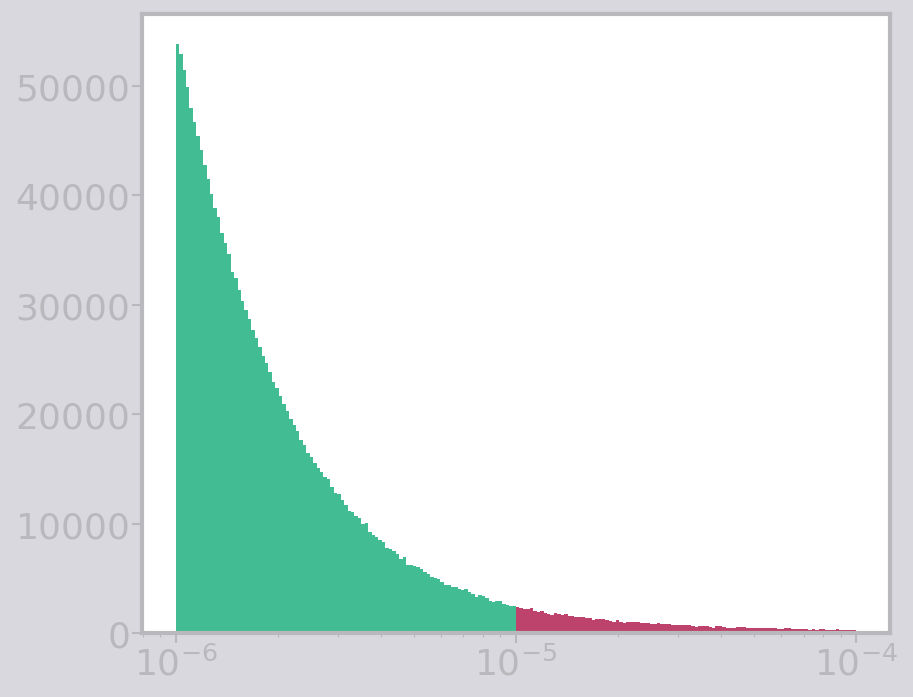

In [29]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.hist(cat_grid_Jy.flatten(), bins=np.geomspace(1e-6, 1e-5, 100))
ax.hist(cat_grid_Jy.flatten(), bins=np.geomspace(1e-5, 1e-4, 100))
plt.xscale('log')
plt.show()

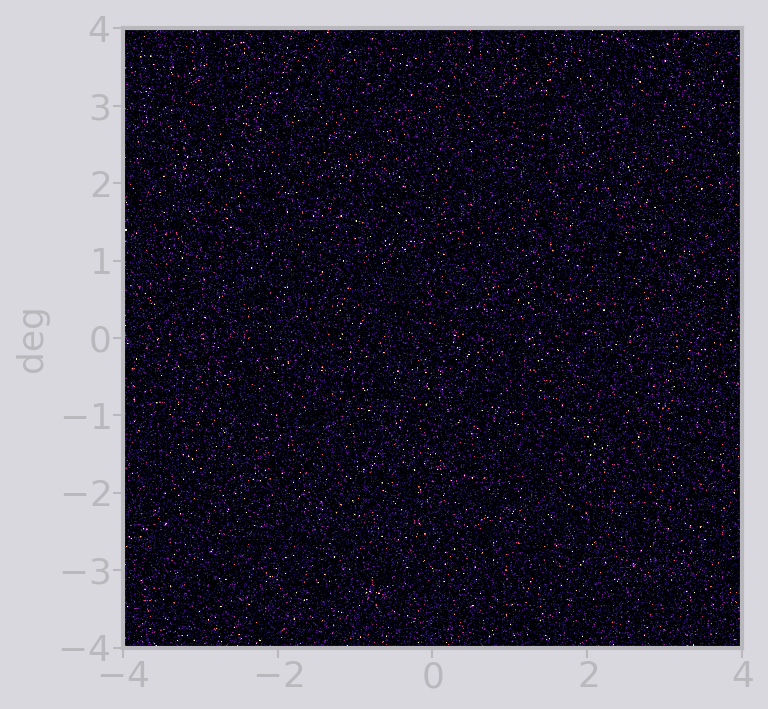

In [30]:
plt.figure(dpi=150)
plt.imshow(np.log(np.clip(cat_grid_Jy, 1e-6, 1)), cmap='magma', vmax=-13,
           extent=(-4, 4, -4, 4))
plt.ylabel('deg')
plt.show()

In [31]:
np.save("../gridded_catalog.Jy_per_arcsec2.fov_8deg.res_5arcsec.npy", cat_grid_Jy)